Using device: cuda
SCENARIO 1: SINGLE WELL

Training PINN for single well scenario...


/beegfs/home/arofenitra.rarivonjy/ai/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 3000/30000
  Total Loss: 0.059979
  PDE: 0.057159, BC: 0.000335, IC: 0.000309, Data: 0.002177
  LR: 1.000000e-03

Epoch 6000/30000
  Total Loss: 0.011536
  PDE: 0.009306, BC: 0.000129, IC: 0.000051, Data: 0.002050
  LR: 5.000000e-04

Epoch 9000/30000
  Total Loss: 0.010986
  PDE: 0.008819, BC: 0.000060, IC: 0.000054, Data: 0.002053
  LR: 5.000000e-04

Epoch 12000/30000
  Total Loss: 0.006824
  PDE: 0.004667, BC: 0.000057, IC: 0.000048, Data: 0.002052
  LR: 2.500000e-04

Epoch 15000/30000
  Total Loss: 0.005899
  PDE: 0.003762, BC: 0.000036, IC: 0.000037, Data: 0.002065
  LR: 1.250000e-04

Epoch 18000/30000
  Total Loss: 0.004566
  PDE: 0.002430, BC: 0.000037, IC: 0.000035, Data: 0.002064
  LR: 1.250000e-04

Epoch 21000/30000
  Total Loss: 0.004065
  PDE: 0.001933, BC: 0.000036, IC: 0.000032, Data: 0.002063
  LR: 6.250000e-05

Epoch 24000/30000
  Total Loss: 0.004009
  PDE: 0.001878, BC: 0.000033, IC: 0.000030, Data: 0.002067
  LR: 6.250000e-05

Epoch 27000/30000
  Total Loss: 0.0

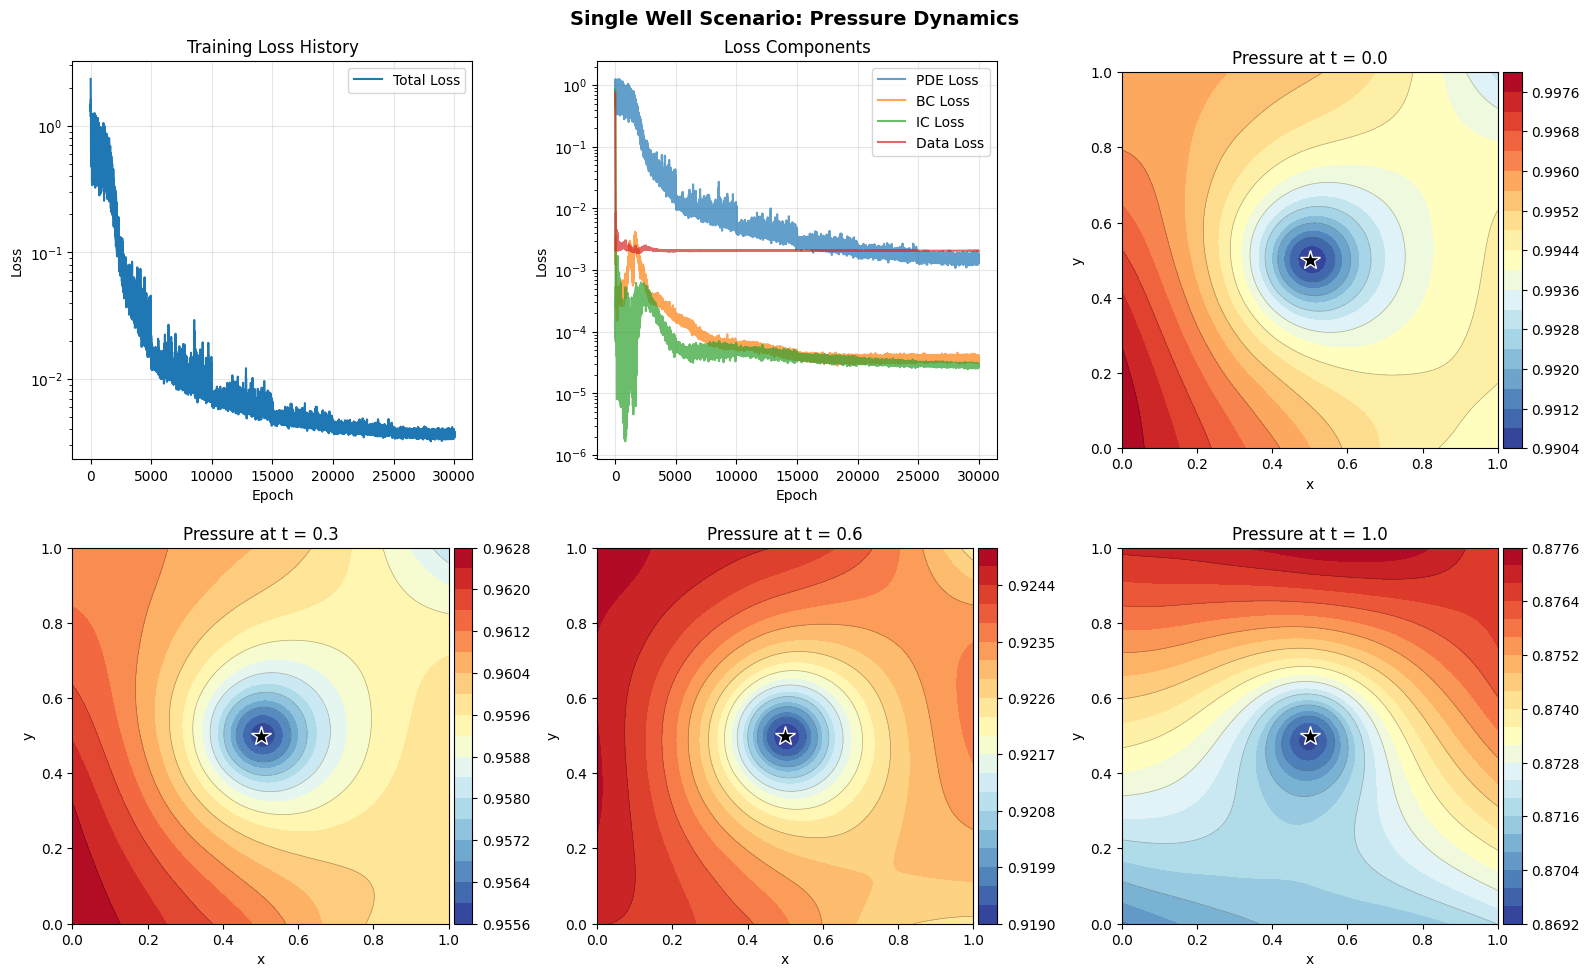

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class PINN(nn.Module):
    """
    Physics-Informed Neural Network for reservoir pressure prediction.
    Architecture: MLP with 3 inputs (x, y, t) and 1 output (pressure p)
    """
    def __init__(self, layers=[3, 40, 40, 40, 1]):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        for i, layer in enumerate(self.layers[:-1]):
            inputs = self.activation(layer(inputs))
        output = self.layers[-1](inputs)
        return output


class ReservoirPINN:
    """
    Main class for training PINN on reservoir pressure dynamics.
    Implements physics-informed loss with PDE, BC, IC, and data constraints.
    """
    def __init__(self, permeability_map=None, well_locations=None, well_rates=None):
        """
        Args:
            permeability_map: 2D numpy array or constant value for permeability k(x,y)
            well_locations: List of (x, y) tuples for well positions
            well_rates: List of production rates (negative for extraction)
        """
        self.model = PINN().to(device)
        self.permeability_map = permeability_map if permeability_map is not None else 10.0
        self.well_locations = well_locations if well_locations is not None else [(0.5, 0.5)]
        self.well_rates = well_rates if well_rates is not None else [-10.0]

        # Loss weights
        self.lambda_data = 1.0
        self.lambda_pde = 1.0
        self.lambda_bc = 1.0
        self.lambda_ic = 1.0

        # Training parameters
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-3,weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5000, gamma=0.5)

        # Domain parameters
        self.p0 = 1.0  # Initial pressure
        self.T_max = 1.0  # Maximum time

    def get_permeability(self, x, y):
        """Get permeability at locations (x, y)"""
        if isinstance(self.permeability_map, (int, float)):
            return torch.ones_like(x) * self.permeability_map
        else:
            # Interpolate from permeability map
            x_np = x.detach().cpu().numpy().flatten()
            y_np = y.detach().cpu().numpy().flatten()
            points = np.column_stack([x_np, y_np])

            # Create grid for interpolation
            nx, ny = self.permeability_map.shape
            xi = np.linspace(0, 1, nx)
            yi = np.linspace(0, 1, ny)
            grid_x, grid_y = np.meshgrid(xi, yi)
            grid_points = np.column_stack([grid_x.flatten(), grid_y.flatten()])

            k_interp = griddata(grid_points, self.permeability_map.flatten(),
                               points, method='linear', fill_value=10.0)
            return torch.tensor(k_interp, dtype=torch.float32).reshape(x.shape).to(device)

    def source_term(self, x, y, t):
        """
        Source term q(x, y, t) representing wells.
        Gaussian distribution around each well location.
        """
        q = torch.zeros_like(x)
        sigma = 0.05  # Well influence radius

        for (wx, wy), rate in zip(self.well_locations, self.well_rates):
            q += rate * torch.exp(-((x - wx)**2 + (y - wy)**2) / (2 * sigma**2))

        return q

    def compute_derivatives(self, x, y, t):
        """Compute all required derivatives using automatic differentiation"""
        x.requires_grad_(True)
        y.requires_grad_(True)
        t.requires_grad_(True)

        p = self.model(x, y, t)

        # First derivatives
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
        p_t = torch.autograd.grad(p, t, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]

        # Second derivatives for Laplacian
        p_xx = torch.autograd.grad(p_x, x, grad_outputs=torch.ones_like(p_x),
                                   create_graph=True, retain_graph=True)[0]
        p_yy = torch.autograd.grad(p_y, y, grad_outputs=torch.ones_like(p_y),
                                   create_graph=True, retain_graph=True)[0]

        return p, p_x, p_y, p_t, p_xx, p_yy

    def pde_loss(self, x, y, t):
        """
        PDE residual: ∂p/∂t = ∇·(k∇p) + q
        For constant k: ∂p/∂t = k(∂²p/∂x² + ∂²p/∂y²) + q
        """
        p, p_x, p_y, p_t, p_xx, p_yy = self.compute_derivatives(x, y, t)

        k = self.get_permeability(x, y)
        q = self.source_term(x, y, t)

        # PDE residual
        laplacian = p_xx + p_yy
        residual = p_t - k * laplacian - q

        return torch.mean(residual**2)

    def boundary_loss(self, n_points=200):
        """
        Neumann boundary conditions: ∂p/∂n = 0 on boundaries
        """
        t_bc = torch.rand(n_points, 1).to(device) * self.T_max

        # Left and right boundaries (x = 0, x = 1)
        x_left = torch.zeros(n_points, 1).to(device)
        x_right = torch.ones(n_points, 1).to(device)
        y_lr = torch.rand(n_points, 1).to(device)

        _, p_x_left, _, _, _, _ = self.compute_derivatives(x_left, y_lr, t_bc)
        _, p_x_right, _, _, _, _ = self.compute_derivatives(x_right, y_lr, t_bc)

        # Bottom and top boundaries (y = 0, y = 1)
        x_bt = torch.rand(n_points, 1).to(device)
        y_bottom = torch.zeros(n_points, 1).to(device)
        y_top = torch.ones(n_points, 1).to(device)

        _, _, p_y_bottom, _, _, _ = self.compute_derivatives(x_bt, y_bottom, t_bc)
        _, _, p_y_top, _, _, _ = self.compute_derivatives(x_bt, y_top, t_bc)

        loss_bc = torch.mean(p_x_left**2) + torch.mean(p_x_right**2) + \
                  torch.mean(p_y_bottom**2) + torch.mean(p_y_top**2)

        return loss_bc

    def initial_loss(self, n_points=500):
        """Initial condition: p(x, y, 0) = p0"""
        x_ic = torch.rand(n_points, 1).to(device)
        y_ic = torch.rand(n_points, 1).to(device)
        t_ic = torch.zeros(n_points, 1).to(device)

        p_pred = self.model(x_ic, y_ic, t_ic)

        return torch.mean((p_pred - self.p0)**2)

    def data_loss(self, x_data, y_data, t_data, p_data):
        """Data fidelity loss"""
        if len(x_data) == 0:
            return torch.tensor(0.0).to(device)

        x_d = torch.tensor(x_data, dtype=torch.float32).reshape(-1, 1).to(device)
        y_d = torch.tensor(y_data, dtype=torch.float32).reshape(-1, 1).to(device)
        t_d = torch.tensor(t_data, dtype=torch.float32).reshape(-1, 1).to(device)
        p_d = torch.tensor(p_data, dtype=torch.float32).reshape(-1, 1).to(device)

        p_pred = self.model(x_d, y_d, t_d)

        return torch.mean((p_pred - p_d)**2)

    def total_loss(self, x_col, y_col, t_col, x_data=[], y_data=[], t_data=[], p_data=[]):
        """Total physics-informed loss"""
        loss_pde = self.pde_loss(x_col, y_col, t_col)
        loss_bc = self.boundary_loss()
        loss_ic = self.initial_loss()
        loss_data = self.data_loss(x_data, y_data, t_data, p_data)

        total = (self.lambda_pde * loss_pde +
                self.lambda_bc * loss_bc +
                self.lambda_ic * loss_ic +
                self.lambda_data * loss_data)

        return total, loss_pde, loss_bc, loss_ic, loss_data

    def train(self, n_epochs=30000, n_collocation=1000,
              x_data=[], y_data=[], t_data=[], p_data=[],
              print_every=1000):
        """Train the PINN"""
        history = {'total': [], 'pde': [], 'bc': [], 'ic': [], 'data': []}

        for epoch in range(n_epochs):
            self.optimizer.zero_grad()

            # Sample collocation points
            x_col = torch.rand(n_collocation, 1, requires_grad=True).to(device)
            y_col = torch.rand(n_collocation, 1, requires_grad=True).to(device)
            t_col = torch.rand(n_collocation, 1, requires_grad=True).to(device) * self.T_max

            # Compute loss
            loss, loss_pde, loss_bc, loss_ic, loss_data = self.total_loss(
                x_col, y_col, t_col, x_data, y_data, t_data, p_data
            )

            # Backward pass
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            # Record history
            history['total'].append(loss.item())
            history['pde'].append(loss_pde.item())
            history['bc'].append(loss_bc.item())
            history['ic'].append(loss_ic.item())
            history['data'].append(loss_data.item())

            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch+1}/{n_epochs}")
                print(f"  Total Loss: {loss.item():.6f}")
                print(f"  PDE: {loss_pde.item():.6f}, BC: {loss_bc.item():.6f}, "
                      f"IC: {loss_ic.item():.6f}, Data: {loss_data.item():.6f}")
                print(f"  LR: {self.scheduler.get_last_lr()[0]:.6e}\n")

        return history

    def predict(self, x, y, t):
        """Make predictions"""
        self.model.eval()
        with torch.no_grad():
            x_t = torch.tensor(x, dtype=torch.float32).reshape(-1, 1).to(device)
            y_t = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
            t_t = torch.tensor(t, dtype=torch.float32).reshape(-1, 1).to(device)
            p_pred = self.model(x_t, y_t, t_t)
        return p_pred.cpu().numpy().flatten()


def visualize_results(pinn, scenario_name, history):
    """Visualize training history and predictions"""
    fig = plt.figure(figsize=(16, 10))

    # Plot loss history
    ax1 = plt.subplot(2, 3, 1)
    ax1.semilogy(history['total'], label='Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss History')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot individual losses
    ax2 = plt.subplot(2, 3, 2)
    ax2.semilogy(history['pde'], label='PDE Loss', alpha=0.7)
    ax2.semilogy(history['bc'], label='BC Loss', alpha=0.7)
    ax2.semilogy(history['ic'], label='IC Loss', alpha=0.7)
    if max(history['data']) > 0:
        ax2.semilogy(history['data'], label='Data Loss', alpha=0.7)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss Components')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Predict pressure field at different times
    n_grid = 100
    x_grid = np.linspace(0, 1, n_grid)
    y_grid = np.linspace(0, 1, n_grid)
    X, Y = np.meshgrid(x_grid, y_grid)

    times = [0.0, 0.3, 0.6, 1.0]
    for idx, t_val in enumerate(times):
        ax = plt.subplot(2, 3, idx + 3)

        x_flat = X.flatten()
        y_flat = Y.flatten()
        t_flat = np.ones_like(x_flat) * t_val

        p_pred = pinn.predict(x_flat, y_flat, t_flat)
        P_pred = p_pred.reshape(X.shape)

        im = ax.contourf(X, Y, P_pred, levels=20, cmap='RdYlBu_r')
        ax.contour(X, Y, P_pred, levels=10, colors='k', linewidths=0.5, alpha=0.3)

        # Mark well locations
        for wx, wy in pinn.well_locations:
            ax.plot(wx, wy, 'k*', markersize=15, markeredgecolor='white', markeredgewidth=1)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Pressure at t = {t_val:.1f}')
        ax.set_aspect('equal')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.suptitle(f'{scenario_name}: Pressure Dynamics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{scenario_name.lower().replace(" ", "_")}_results.png', dpi=150, bbox_inches='tight')
    plt.show()


# ==================== SCENARIO 1: SINGLE WELL ====================
print("=" * 70)
print("SCENARIO 1: SINGLE WELL")
print("=" * 70)

# Single well at center
single_well_pinn = ReservoirPINN(
    permeability_map=10.0,
    well_locations=[(0.5, 0.5)],
    well_rates=[-10.0]
)

# Generate synthetic data (sparse measurements)
np.random.seed(123)
n_data = 20
x_data_single = np.random.rand(n_data)
y_data_single = np.random.rand(n_data)
t_data_single = np.random.rand(n_data)
# Synthetic data: pressure decreases near well over time
p_data_single = 1.0 - 0.3 * t_data_single * np.exp(-((x_data_single - 0.5)**2 + (y_data_single - 0.5)**2) / 0.1)

print("\nTraining PINN for single well scenario...")
history_single = single_well_pinn.train(
    n_epochs=30000,
    n_collocation=1000,
    x_data=x_data_single,
    y_data=y_data_single,
    t_data=t_data_single,
    p_data=p_data_single,
    print_every=3000
)

visualize_results(single_well_pinn, "Single Well Scenario", history_single)




SCENARIO 2: MULTIPLE WELLS

Training PINN for multiple wells scenario...
Epoch 3000/30000
  Total Loss: 0.893437
  PDE: 0.888957, BC: 0.003870, IC: 0.000097, Data: 0.000513
  LR: 1.000000e-03

Epoch 6000/30000
  Total Loss: 0.504189
  PDE: 0.502344, BC: 0.001063, IC: 0.000091, Data: 0.000691
  LR: 5.000000e-04

Epoch 9000/30000
  Total Loss: 0.399954
  PDE: 0.397147, BC: 0.002129, IC: 0.000052, Data: 0.000626
  LR: 5.000000e-04

Epoch 12000/30000
  Total Loss: 0.150239
  PDE: 0.147143, BC: 0.002335, IC: 0.000107, Data: 0.000654
  LR: 2.500000e-04

Epoch 15000/30000
  Total Loss: 0.092602
  PDE: 0.090688, BC: 0.000943, IC: 0.000123, Data: 0.000848
  LR: 1.250000e-04

Epoch 18000/30000
  Total Loss: 0.087475
  PDE: 0.085754, BC: 0.000752, IC: 0.000121, Data: 0.000848
  LR: 1.250000e-04

Epoch 21000/30000
  Total Loss: 0.080196
  PDE: 0.078494, BC: 0.000753, IC: 0.000126, Data: 0.000823
  LR: 6.250000e-05

Epoch 24000/30000
  Total Loss: 0.055036
  PDE: 0.053337, BC: 0.000757, IC: 0.0001

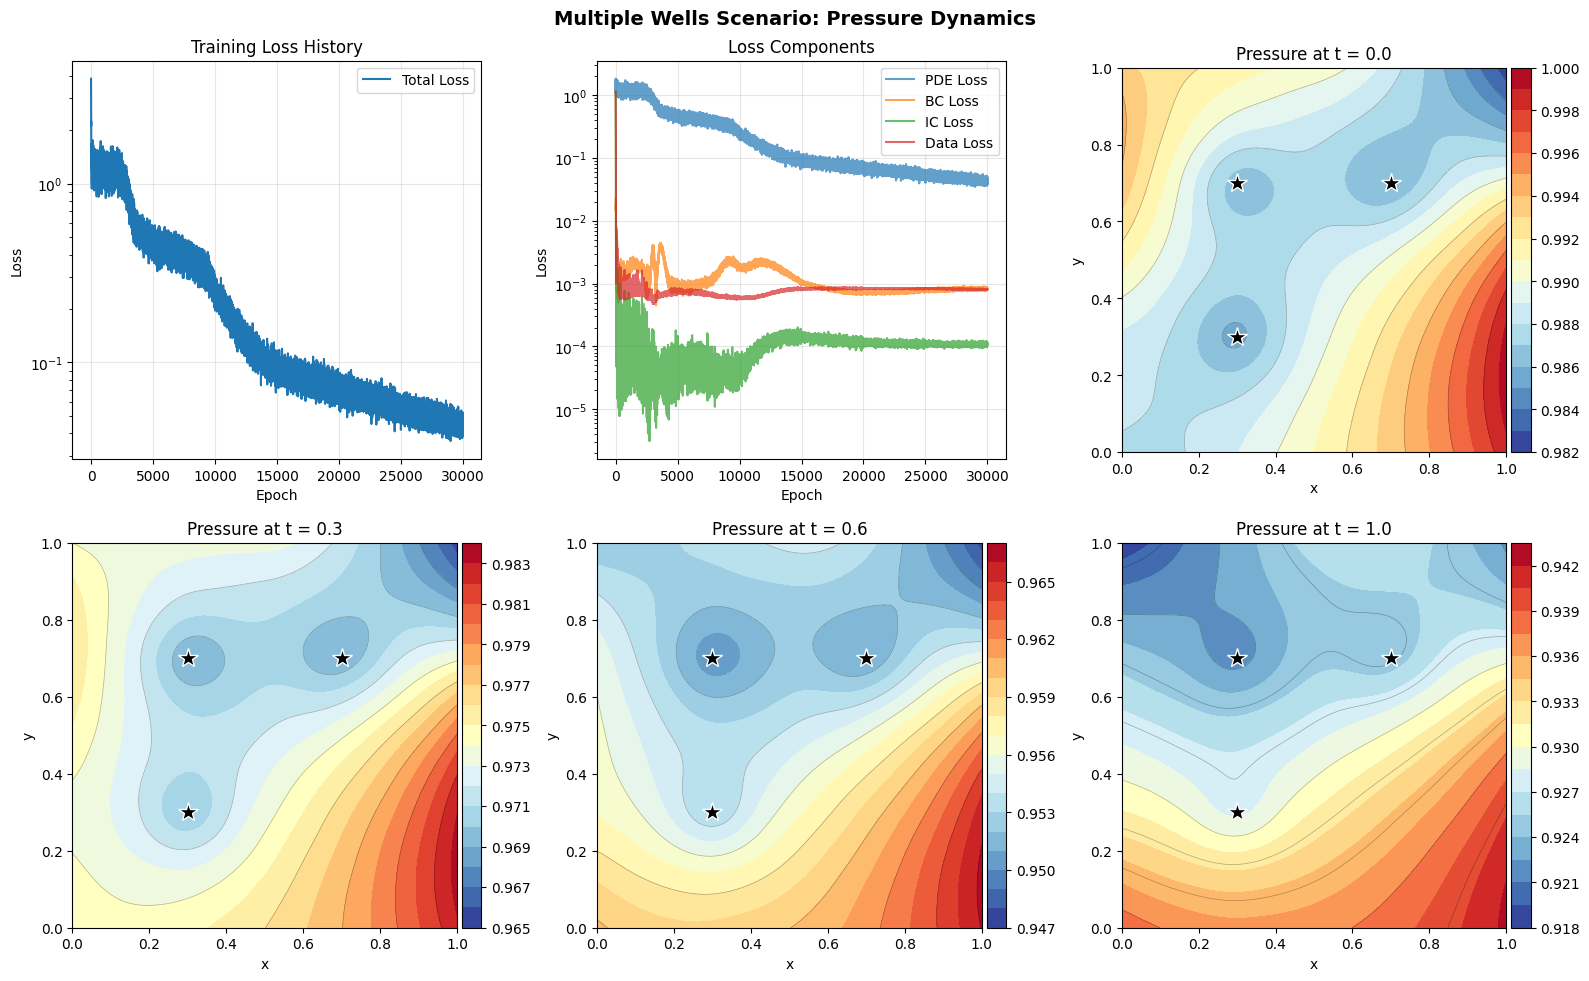


Training completed! Check the generated plots for results.


In [2]:

# ==================== SCENARIO 2: MULTIPLE WELLS ====================
print("\n" + "=" * 70)
print("SCENARIO 2: MULTIPLE WELLS")
print("=" * 70)

# Multiple wells configuration
multi_well_pinn = ReservoirPINN(
    permeability_map=10.0,
    well_locations=[(0.3, 0.3), (0.7, 0.7), (0.3, 0.7)],
    well_rates=[-8.0, -8.0, -8.0]
)

# Generate synthetic data for multiple wells
np.random.seed(456)
n_data_multi = 30
x_data_multi = np.random.rand(n_data_multi)
y_data_multi = np.random.rand(n_data_multi)
t_data_multi = np.random.rand(n_data_multi)

# Pressure affected by multiple wells
p_data_multi = 1.0
for (wx, wy), rate in zip(multi_well_pinn.well_locations, multi_well_pinn.well_rates):
    p_data_multi -= 0.15 * t_data_multi * np.exp(-((x_data_multi - wx)**2 + (y_data_multi - wy)**2) / 0.08)

print("\nTraining PINN for multiple wells scenario...")
history_multi = multi_well_pinn.train(
    n_epochs=30000,
    n_collocation=1500,
    x_data=x_data_multi,
    y_data=y_data_multi,
    t_data=t_data_multi,
    p_data=p_data_multi,
    print_every=3000
)

visualize_results(multi_well_pinn, "Multiple Wells Scenario", history_multi)

print("\n" + "=" * 70)
print("Training completed! Check the generated plots for results.")
print("=" * 70)


Training PINN for multiple wells scenario...
Epoch 3000/30000
  Total Loss: 0.000032
  PDE: 0.000008, BC: 0.000003, IC: 0.000001, Data: 0.000020
  LR: 1.000000e-03

Epoch 6000/30000
  Total Loss: 0.000017
  PDE: 0.000001, BC: 0.000001, IC: 0.000000, Data: 0.000014
  LR: 5.000000e-04

Epoch 9000/30000
  Total Loss: 0.000013
  PDE: 0.000001, BC: 0.000000, IC: 0.000000, Data: 0.000012
  LR: 5.000000e-04

Epoch 12000/30000
  Total Loss: 0.000013
  PDE: 0.000001, BC: 0.000000, IC: 0.000000, Data: 0.000012
  LR: 2.500000e-04

Epoch 15000/30000
  Total Loss: 0.000013
  PDE: 0.000001, BC: 0.000000, IC: 0.000000, Data: 0.000011
  LR: 1.250000e-04

Epoch 18000/30000
  Total Loss: 0.000012
  PDE: 0.000000, BC: 0.000000, IC: 0.000000, Data: 0.000011
  LR: 1.250000e-04

Epoch 21000/30000
  Total Loss: 0.000012
  PDE: 0.000000, BC: 0.000000, IC: 0.000000, Data: 0.000011
  LR: 6.250000e-05

Epoch 24000/30000
  Total Loss: 0.000012
  PDE: 0.000000, BC: 0.000000, IC: 0.000000, Data: 0.000011
  LR: 6.2

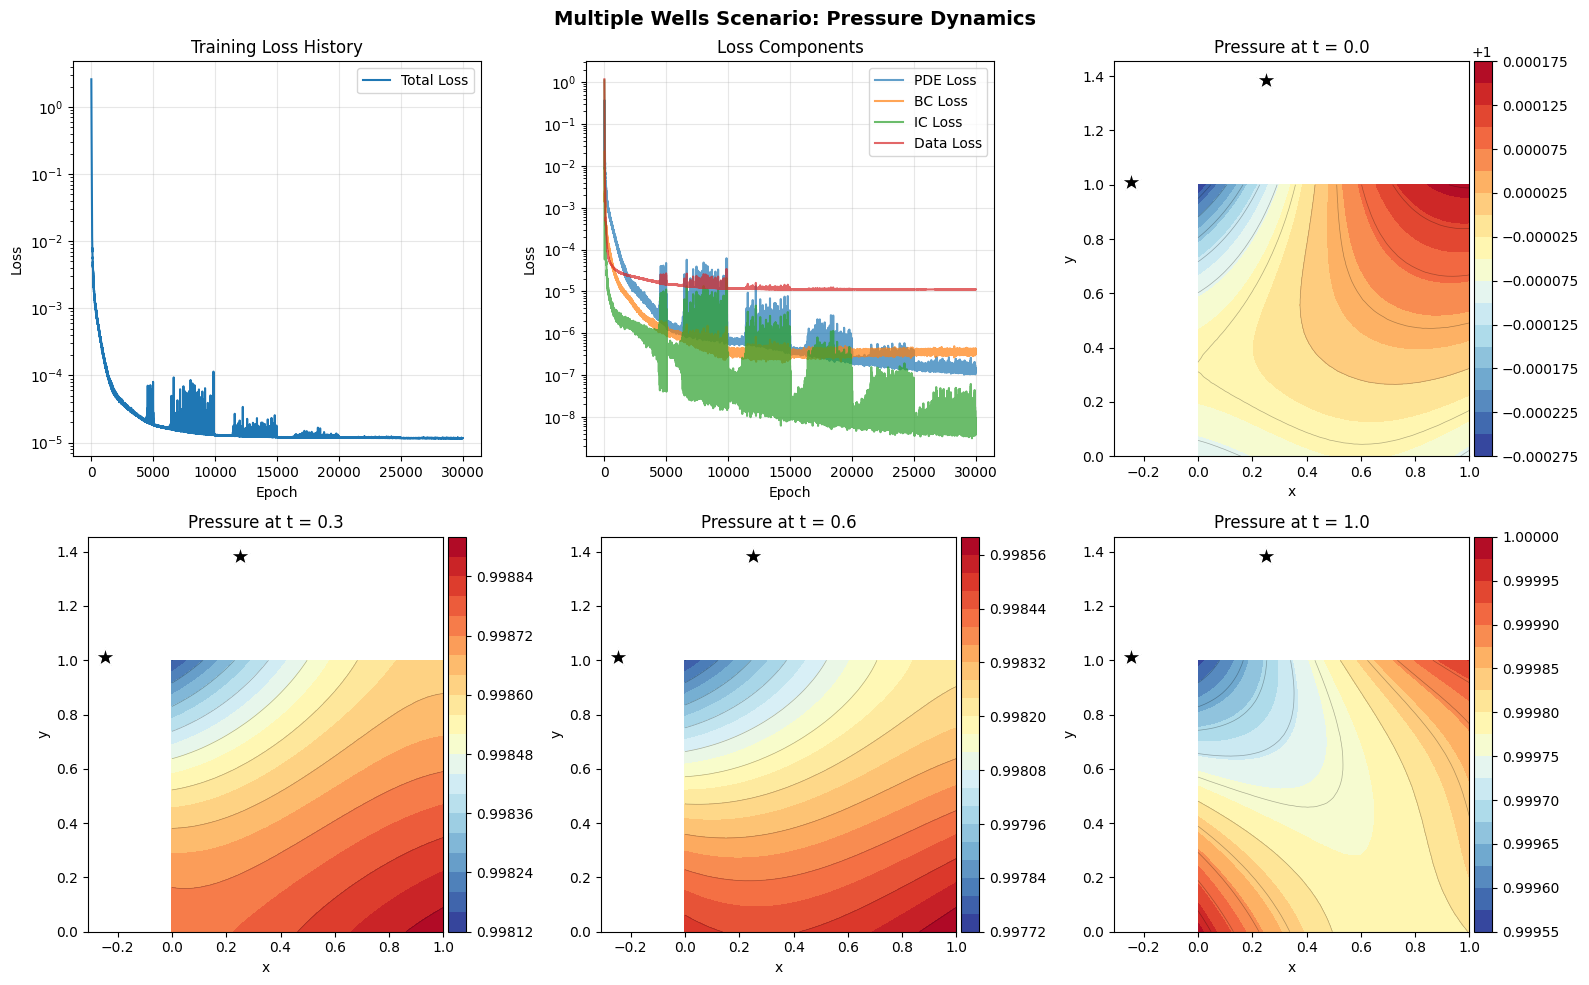


Training completed! Check the generated plots for results.


In [3]:
# Multiple wells configuration
multi_well_pinn = ReservoirPINN(
    permeability_map=10.0,
    well_locations=np.random.randn(2,2),
    well_rates=[-8.0, -8.0, -8.0]
)

# Generate synthetic data for multiple wells
np.random.seed(456)
n_data_multi = 30
x_data_multi = np.random.rand(n_data_multi)
y_data_multi = np.random.rand(n_data_multi)
t_data_multi = np.random.rand(n_data_multi)

# Pressure affected by multiple wells
p_data_multi = 1.0
for (wx, wy), rate in zip(multi_well_pinn.well_locations, multi_well_pinn.well_rates):
    p_data_multi -= 0.15 * t_data_multi * np.exp(-((x_data_multi - wx)**2 + (y_data_multi - wy)**2) / 0.08)

print("\nTraining PINN for multiple wells scenario...")
history_multi = multi_well_pinn.train(
    n_epochs=30000,
    n_collocation=1500,
    x_data=x_data_multi,
    y_data=y_data_multi,
    t_data=t_data_multi,
    p_data=p_data_multi,
    print_every=3000
)

visualize_results(multi_well_pinn, "Multiple Wells Scenario", history_multi)

print("\n" + "=" * 70)
print("Training completed! Check the generated plots for results.")
print("=" * 70)


Training PINN for multiple wells scenario...


Epoch 3000/30000
  Total Loss: 0.582160
  PDE: 0.578742, BC: 0.002144, IC: 0.000108, Data: 0.001165
  LR: 1.000000e-03

Epoch 6000/30000
  Total Loss: 0.499930
  PDE: 0.495023, BC: 0.003733, IC: 0.000086, Data: 0.001087
  LR: 5.000000e-04

Epoch 9000/30000
  Total Loss: 0.229501
  PDE: 0.226849, BC: 0.001226, IC: 0.000158, Data: 0.001268
  LR: 5.000000e-04

Epoch 12000/30000
  Total Loss: 0.190049
  PDE: 0.187332, BC: 0.001339, IC: 0.000068, Data: 0.001310
  LR: 2.500000e-04

Epoch 15000/30000
  Total Loss: 0.146874
  PDE: 0.143731, BC: 0.001704, IC: 0.000087, Data: 0.001352
  LR: 1.250000e-04

Epoch 18000/30000
  Total Loss: 0.148021
  PDE: 0.144637, BC: 0.001865, IC: 0.000066, Data: 0.001453
  LR: 1.250000e-04

Epoch 21000/30000
  Total Loss: 0.089622
  PDE: 0.086090, BC: 0.001888, IC: 0.000072, Data: 0.001572
  LR: 6.250000e-05

Epoch 24000/30000
  Total Loss: 0.079247
  PDE: 0.075906, BC: 0.001670, IC: 0.000092, Data: 0.001579
  LR: 6.250000e-05

Epoch 27000/30000
  Total Loss: 0.0

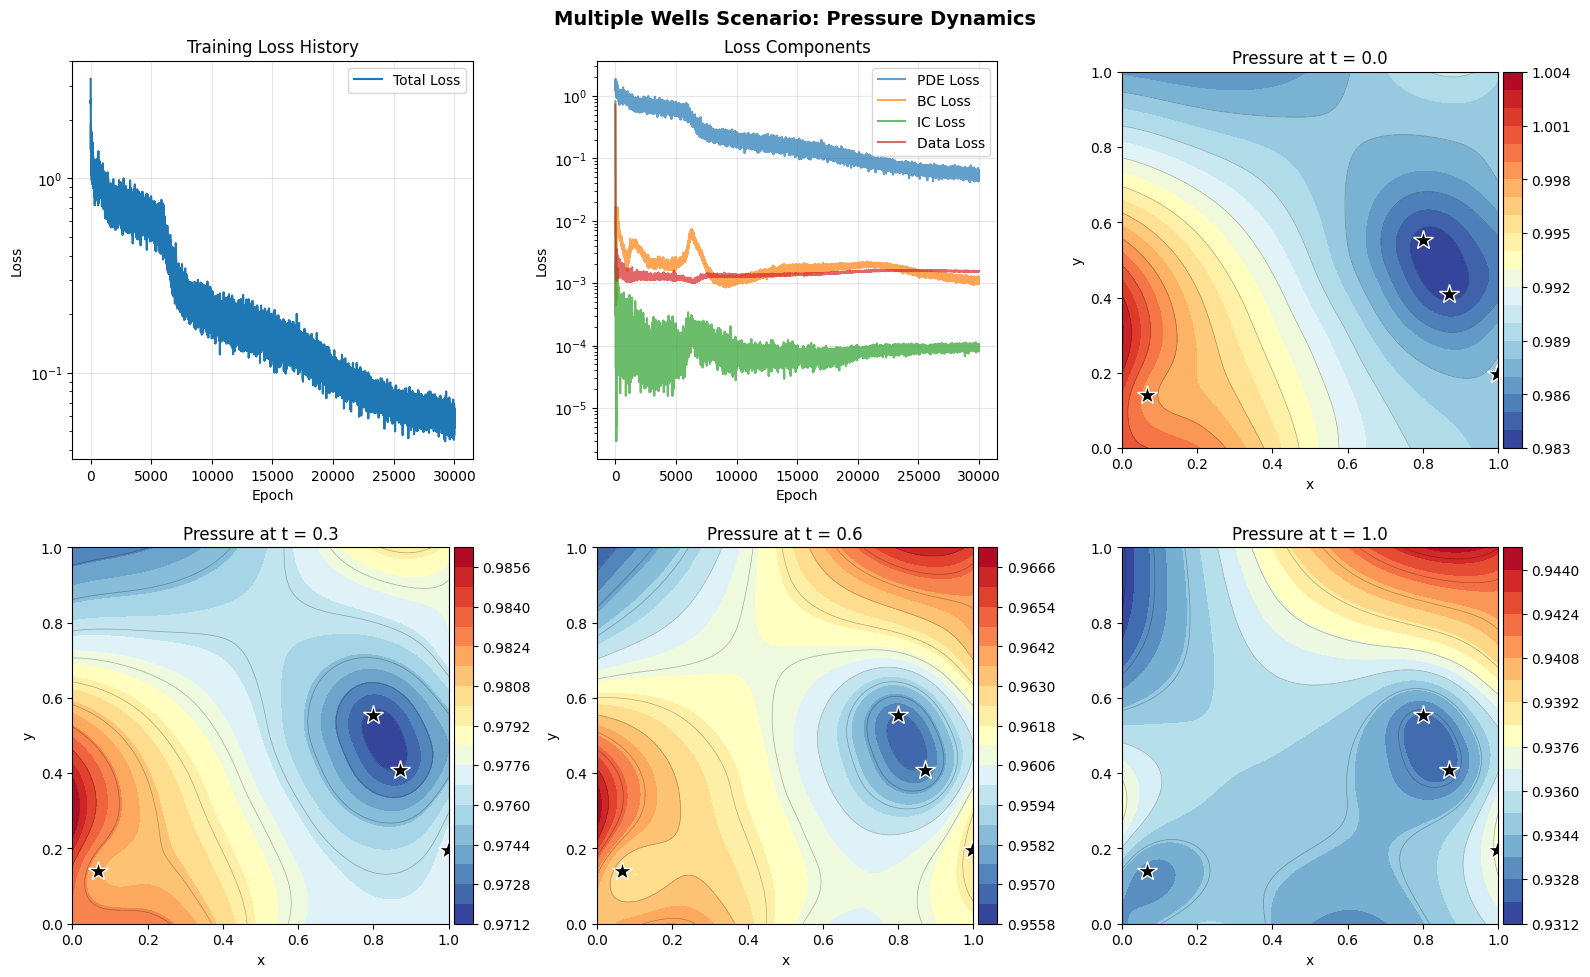


Training completed! Check the generated plots for results.


In [4]:
# Multiple wells configuration
multi_well_pinn = ReservoirPINN(
    permeability_map=10.0,
    well_locations=[np.random.uniform(size=2),np.random.uniform(size=2),np.random.uniform(size=2),np.random.uniform(size=2)],
    well_rates=[-8.0, -8.0, -8.0]
)

# Generate synthetic data for multiple wells
np.random.seed(456)
n_data_multi = 30
x_data_multi = np.random.rand(n_data_multi)
y_data_multi = np.random.rand(n_data_multi)
t_data_multi = np.random.rand(n_data_multi)

# Pressure affected by multiple wells
p_data_multi = 1.0
for (wx, wy), rate in zip(multi_well_pinn.well_locations, multi_well_pinn.well_rates):
    p_data_multi -= 0.15 * t_data_multi * np.exp(-((x_data_multi - wx)**2 + (y_data_multi - wy)**2) / 0.08)

print("\nTraining PINN for multiple wells scenario...")
history_multi = multi_well_pinn.train(
    n_epochs=30000,
    n_collocation=1500,
    x_data=x_data_multi,
    y_data=y_data_multi,
    t_data=t_data_multi,
    p_data=p_data_multi,
    print_every=3000
)

visualize_results(multi_well_pinn, "Multiple Wells Scenario", history_multi)

print("\n" + "=" * 70)
print("Training completed! Check the generated plots for results.")
print("=" * 70)

# More complex case

Using device: cpu
COMPARING SINE vs STANDARD NETWORKS ON COMPLEX RESERVOIR SCENARIO

1. Training Sine Activation Network...
Epoch 2000/50000 (Stage 1)
  Total Loss: 62.066322
  PDE: 62.058426, BC: 0.006927, IC: 0.000970
  LR: 6.40e-04, Network: sine

Advanced to curriculum stage 2: Multiple wells (2 producers, 1 injector)
Learning rate updated to: 0.0005
Epoch 4000/50000 (Stage 2)
  Total Loss: 46.503098
  PDE: 46.501278, BC: 0.001381, IC: 0.000437
  LR: 3.20e-04, Network: sine

Advanced to curriculum stage 3: Complex 5-spot pattern
Learning rate updated to: 0.0001
Epoch 6000/50000 (Stage 3)
  Total Loss: 51.284416
  PDE: 51.282623, BC: 0.001347, IC: 0.000445
  LR: 8.00e-05, Network: sine

Epoch 8000/50000 (Stage 3)
  Total Loss: 46.902653
  PDE: 46.900822, BC: 0.001370, IC: 0.000463
  LR: 5.12e-05, Network: sine

Epoch 10000/50000 (Stage 3)
  Total Loss: 38.860596
  PDE: 38.858875, BC: 0.001286, IC: 0.000435
  LR: 3.28e-05, Network: sine

Epoch 12000/50000 (Stage 3)
  Total Loss: 46.3

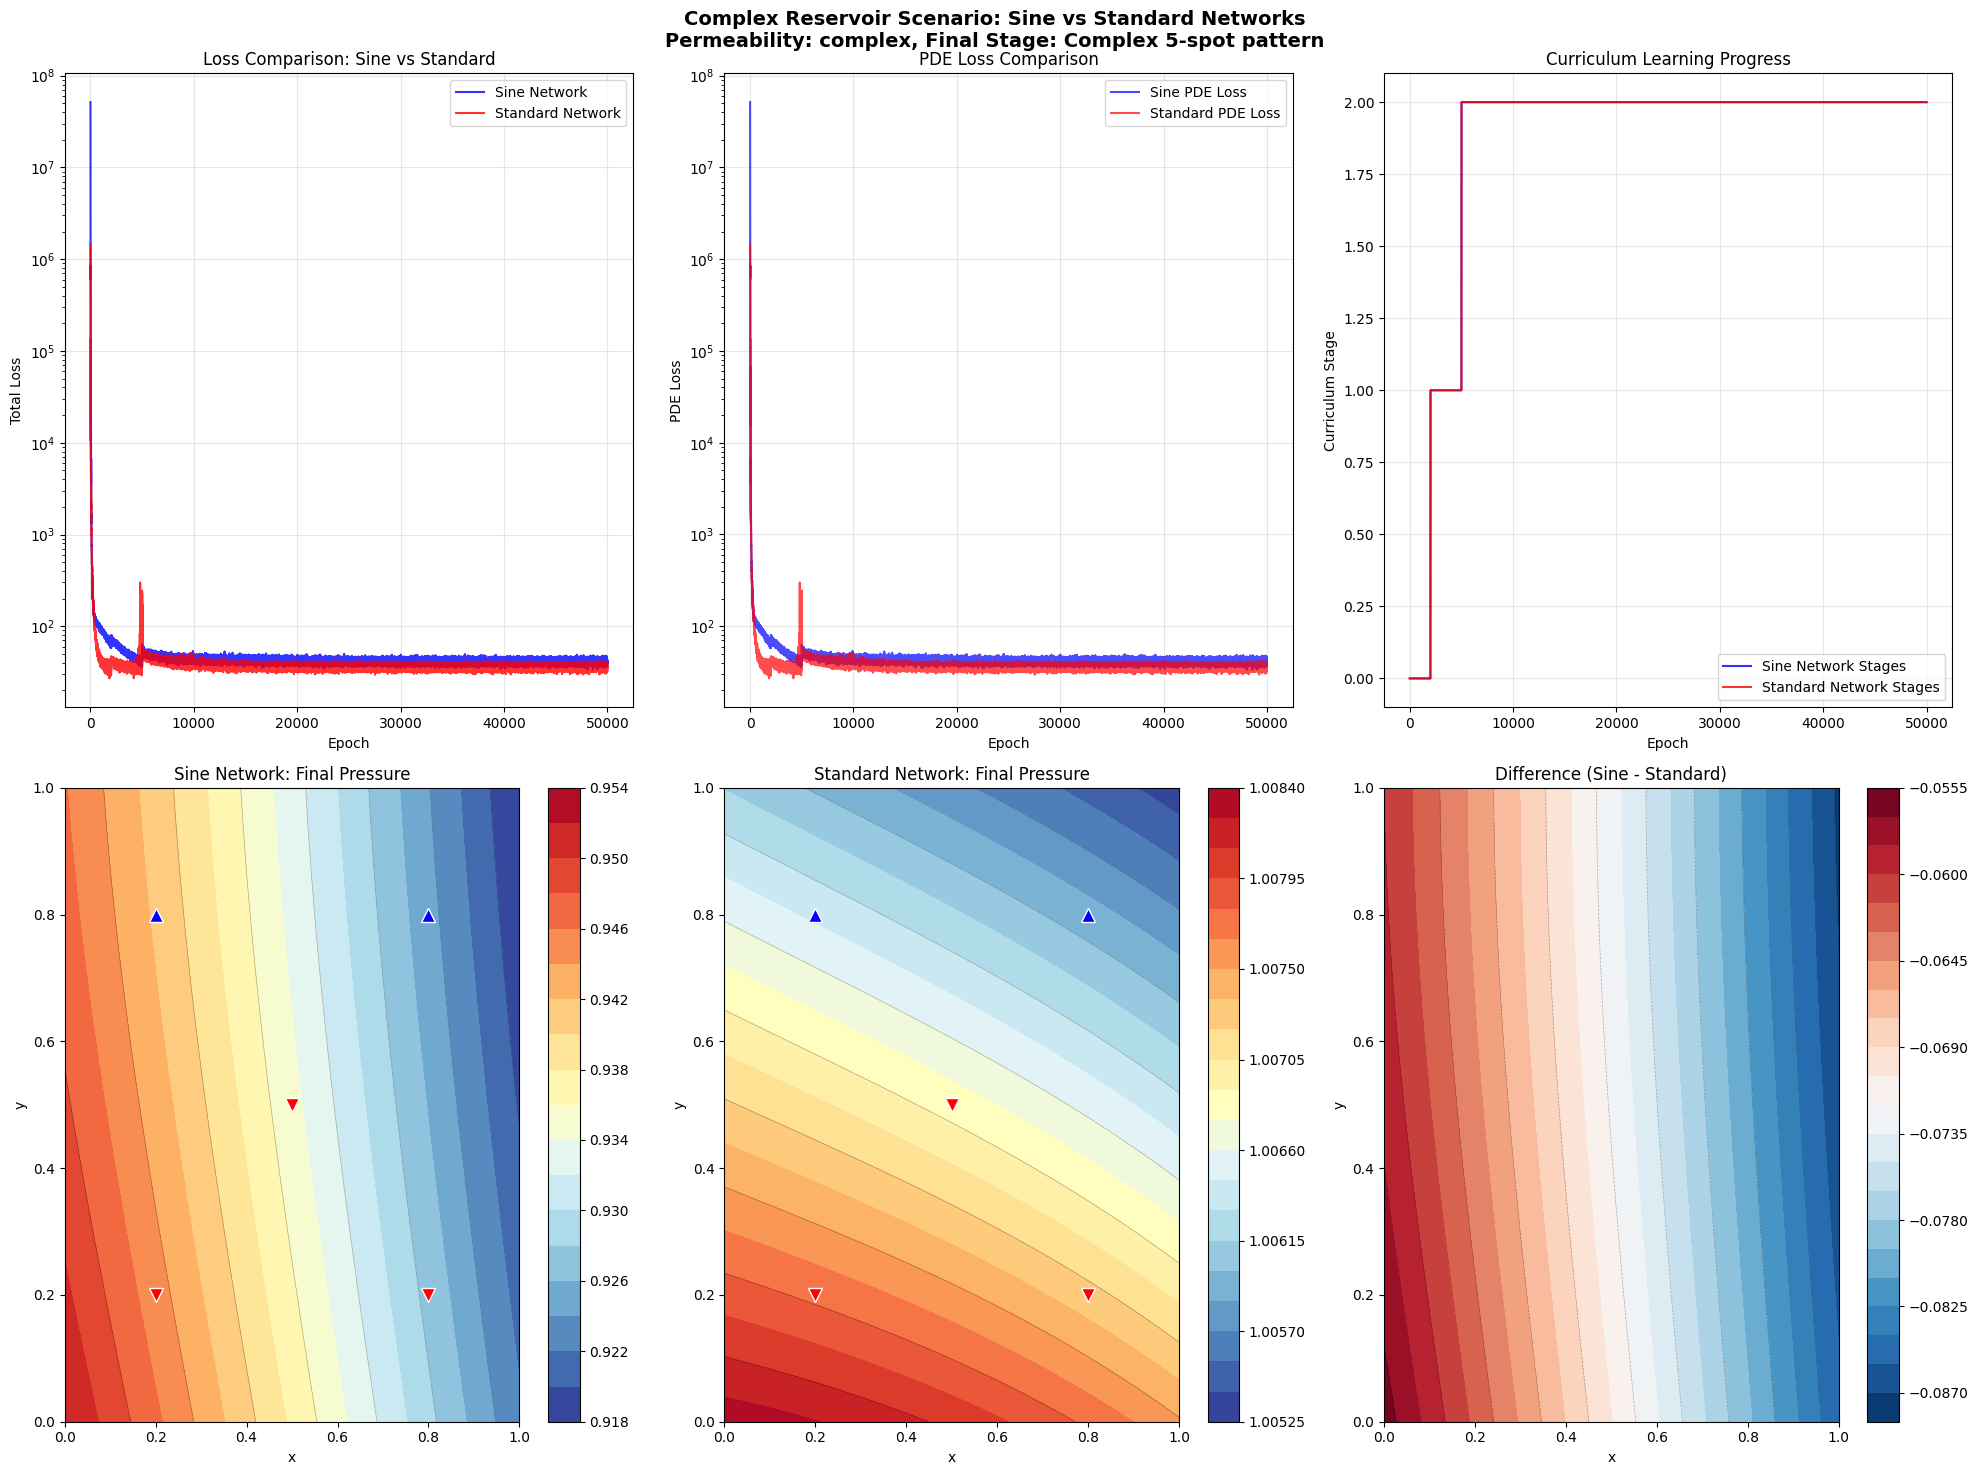


FINAL COMPARISON RESULTS:
Sine Network Final Loss: 36.826668
Standard Network Final Loss: 35.194729
Relative Performance: 1.046x


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch.optim as optim

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== SINE ACTIVATION NETWORK ====================
class Sin(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

class MLPPeriodic(nn.Module):
    """MLP with sine activation for periodic/oscillatory problems"""
    def __init__(self, block_out_channels=[3, 50, 50, 50, 1], seed=42):
        super().__init__()
        torch.manual_seed(seed)

        layers = []
        for i in range(len(block_out_channels) - 1):
            in_channels = block_out_channels[i]
            out_channels = block_out_channels[i + 1]
            layers.append(nn.Linear(in_channels, out_channels))
            if i < len(block_out_channels) - 2:
                layers.append(Sin())
        self.layers = nn.Sequential(*layers)

        # Initialize weights for sine networks
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)

class MLPStandard(nn.Module):
    """Standard MLP with Tanh activation"""
    def __init__(self, layers=[3, 50, 50, 50, 1]):
        super(MLPStandard, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        output = self.layers[-1](x)
        return output

# ==================== COMPLEX RESERVOIR SCENARIO ====================
class ComplexReservoirPINN:
    """
    Enhanced PINN for complex reservoir scenarios with:
    - Heterogeneous permeability fields
    - Multiple well types (producers, injectors)
    - Fault zones and geological barriers
    - Time-varying well rates
    - Curriculum learning
    """

    def __init__(self, network_type='sine', permeability_config='complex',
                 curriculum_stages=3, domain_size=(1.0, 1.0)):
        """
        Args:
            network_type: 'sine' or 'standard'
            permeability_config: 'simple', 'channels', 'faults', 'complex'
            curriculum_stages: Number of curriculum learning stages
            domain_size: (Lx, Ly) size of reservoir domain
        """
        self.network_type = network_type
        if network_type == 'sine':
            self.model = MLPPeriodic([3, 64, 64, 64, 64, 1]).to(device)
        else:
            self.model = MLPStandard([3, 64, 64, 64, 64, 1]).to(device)

        self.curriculum_stages = curriculum_stages
        self.current_stage = 0
        self.domain_size = domain_size
        self.Lx, self.Ly = domain_size

        # Complex permeability field
        self.permeability_config = permeability_config
        self.permeability_field = self._create_permeability_field(permeability_config)

        # Complex well configuration
        self.well_configurations = self._create_well_configurations()

        # Training parameters with curriculum
        self.stage_epochs = [2000, 3000, 5000]#,000,15000]  # Epochs per stage
        self.stage_learning_rates = [1e-3, 5e-4, 1e-4]

        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.stage_learning_rates[0], weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.8)

        # Physical parameters
        self.p0 = 1.0  # Initial pressure
        self.T_max = 2.0  # Maximum time
        self.mu = 1.0  # Viscosity
        self.ct = 1e-3  # Compressibility

        # Loss weights that evolve with curriculum
        self.lambda_pde = 1.0
        self.lambda_bc = 1.0
        self.lambda_ic = 1.0
        self.lambda_data = 1.0

    def _create_permeability_field(self, config):
        """Create complex permeability fields"""
        if config == 'simple':
            return lambda x, y: torch.ones_like(x) * 10.0

        elif config == 'channels':
            # High permeability channels
            def k_func(x, y):
                k = torch.ones_like(x) * 5.0  # Background
                # Channel 1
                channel1 = torch.logical_and(
                    torch.abs(y - 0.3 * self.Ly) < 0.1 * self.Ly,
                    x > 0.2 * self.Lx
                )
                k[channel1] = 50.0
                # Channel 2
                channel2 = torch.logical_and(
                    torch.abs(x - 0.7 * self.Lx) < 0.08 * self.Lx,
                    y < 0.8 * self.Ly
                )
                k[channel2] = 40.0
                return k
            return k_func

        elif config == 'faults':
            # Fault zones with barriers
            def k_func(x, y):
                k = torch.ones_like(x) * 8.0
                # Fault barrier 1
                fault1 = torch.abs(x - y) < 0.05 * self.Lx
                k[fault1] = 1.0
                # High perm zone
                high_zone = torch.logical_and(
                    x > 0.6 * self.Lx,
                    y < 0.4 * self.Ly
                )
                k[high_zone] = 30.0
                return k
            return k_func

        elif config == 'complex':
            # Combined complex field
            def k_func(x, y):
                k = torch.ones_like(x) * 6.0

                # Sinusoidal high-perm layers
                layer_pattern = torch.sin(3 * np.pi * x / self.Lx) * torch.sin(2 * np.pi * y / self.Ly)
                high_layers = layer_pattern > 0.3
                k[high_layers] = 25.0

                # Low-perm barriers
                barrier1 = torch.logical_and(
                    torch.abs(x - 0.4 * self.Lx) < 0.02 * self.Lx,
                    y > 0.3 * self.Ly
                )
                k[barrier1] = 0.5

                barrier2 = torch.logical_and(
                    torch.abs(y - 0.7 * self.Ly) < 0.03 * self.Ly,
                    x < 0.8 * self.Lx
                )
                k[barrier2] = 0.8

                return k
            return k_func

    def _create_well_configurations(self):
        """Create complex well configurations"""
        stages = []

        # Stage 1: Simple single well
        stages.append({
            'wells': [{'location': (0.5 * self.Lx, 0.5 * self.Ly), 'rate': -8.0, 'type': 'producer'}],
            'description': 'Single producer well'
        })

        # Stage 2: Multiple wells
        stages.append({
            'wells': [
                {'location': (0.3 * self.Lx, 0.3 * self.Ly), 'rate': -6.0, 'type': 'producer'},
                {'location': (0.7 * self.Lx, 0.7 * self.Ly), 'rate': -6.0, 'type': 'producer'},
                {'location': (0.5 * self.Lx, 0.8 * self.Ly), 'rate': 4.0, 'type': 'injector'}
            ],
            'description': 'Multiple wells (2 producers, 1 injector)'
        })

        # Stage 3: Complex well pattern with time-varying rates
        stages.append({
            'wells': [
                {'location': (0.2 * self.Lx, 0.2 * self.Ly), 'rate': -5.0, 'type': 'producer'},
                {'location': (0.8 * self.Lx, 0.2 * self.Ly), 'rate': -5.0, 'type': 'producer'},
                {'location': (0.2 * self.Lx, 0.8 * self.Ly), 'rate': 6.0, 'type': 'injector'},
                {'location': (0.8 * self.Lx, 0.8 * self.Ly), 'rate': 6.0, 'type': 'injector'},
                {'location': (0.5 * self.Lx, 0.5 * self.Ly), 'rate': -3.0, 'type': 'producer'}
            ],
            'description': 'Complex 5-spot pattern'
        })

        return stages

    def get_current_wells(self):
        """Get wells for current curriculum stage"""
        return self.well_configurations[min(self.current_stage, len(self.well_configurations)-1)]['wells']

    def get_permeability(self, x, y):
        """Get permeability at locations (x, y)"""
        return self.permeability_field(x, y)

    def source_term(self, x, y, t):
        """Complex source term with time-varying rates"""
        q = torch.zeros_like(x)
        sigma = 0.08  # Well influence radius

        wells = self.get_current_wells()

        for well in wells:
            wx, wy = well['location']
            base_rate = well['rate']

            # Time-varying rates for complex scenarios
            if self.current_stage >= 2:  # Stage 3: time variation
                if well['type'] == 'injector':
                    rate = base_rate * (1.0 + 0.3 * torch.sin(2 * np.pi * t / self.T_max))
                else:
                    rate = base_rate * (1.0 - 0.2 * torch.cos(np.pi * t / self.T_max))
            else:
                rate = base_rate

            # Gaussian well model
            distance_sq = (x - wx)**2 + (y - wy)**2
            q += rate * torch.exp(-distance_sq / (2 * sigma**2))

        return q

    def compute_derivatives(self, x, y, t):
        """Compute derivatives with automatic differentiation"""
        x.requires_grad_(True)
        y.requires_grad_(True)
        t.requires_grad_(True)

        # Concatenate inputs
        inputs = torch.cat([x, y, t], dim=1)
        p = self.model(inputs)

        # First derivatives
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
        p_t = torch.autograd.grad(p, t, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]

        # Second derivatives
        p_xx = torch.autograd.grad(p_x, x, grad_outputs=torch.ones_like(p_x),
                                   create_graph=True, retain_graph=True)[0]
        p_yy = torch.autograd.grad(p_y, y, grad_outputs=torch.ones_like(p_y),
                                   create_graph=True, retain_graph=True)[0]

        return p, p_x, p_y, p_t, p_xx, p_yy

    def pde_loss(self, x, y, t):
        """PDE residual for compressible flow"""
        p, p_x, p_y, p_t, p_xx, p_yy = self.compute_derivatives(x, y, t)

        k = self.get_permeability(x, y)
        q = self.source_term(x, y, t)

        # Diffusivity equation: ∂p/∂t = (k/φμct) ∇²p + q/φ
        # For simplicity, assume φ=0.2 constant
        phi = 0.2
        eta = k / (phi * self.mu * self.ct)

        laplacian = p_xx + p_yy
        residual = p_t - eta * laplacian - q / phi

        return torch.mean(residual**2)

    def boundary_loss(self, n_points=300):
        """Mixed boundary conditions"""
        t_bc = torch.rand(n_points, 1).to(device) * self.T_max

        # Dirichlet on left boundary
        x_left = torch.zeros(n_points, 1).to(device)
        y_left = torch.rand(n_points, 1).to(device) * self.Ly
        p_left, _, _, _, _, _ = self.compute_derivatives(x_left, y_left, t_bc)
        loss_dirichlet = torch.mean((p_left - self.p0)**2)

        # Neumann on other boundaries
        x_right = torch.ones(n_points, 1).to(device) * self.Lx
        y_right = torch.rand(n_points, 1).to(device) * self.Ly
        _, p_x_right, _, _, _, _ = self.compute_derivatives(x_right, y_right, t_bc)

        x_top = torch.rand(n_points, 1).to(device) * self.Lx
        y_top = torch.ones(n_points, 1).to(device) * self.Ly
        _, _, p_y_top, _, _, _ = self.compute_derivatives(x_top, y_top, t_bc)

        x_bottom = torch.rand(n_points, 1).to(device) * self.Lx
        y_bottom = torch.zeros(n_points, 1).to(device)
        _, _, p_y_bottom, _, _, _ = self.compute_derivatives(x_bottom, y_bottom, t_bc)

        loss_neumann = torch.mean(p_x_right**2) + torch.mean(p_y_top**2) + torch.mean(p_y_bottom**2)

        return loss_dirichlet + 0.1 * loss_neumann

    def initial_loss(self, n_points=500):
        """Initial condition"""
        x_ic = torch.rand(n_points, 1).to(device) * self.Lx
        y_ic = torch.rand(n_points, 1).to(device) * self.Ly
        t_ic = torch.zeros(n_points, 1).to(device)

        inputs = torch.cat([x_ic, y_ic, t_ic], dim=1)
        p_pred = self.model(inputs)

        return torch.mean((p_pred - self.p0)**2)

    def update_curriculum_stage(self, epoch, total_epochs):
        """Update curriculum learning stage based on progress"""
        stage_boundaries = np.cumsum(self.stage_epochs)

        for i, boundary in enumerate(stage_boundaries):
            if epoch < boundary:
                new_stage = i
                break
        else:
            new_stage = len(self.stage_epochs) - 1

        if new_stage != self.current_stage:
            self.current_stage = new_stage
            # Update learning rate for new stage
            new_lr = self.stage_learning_rates[new_stage]
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = new_lr
            print(f"Advanced to curriculum stage {new_stage + 1}: {self.well_configurations[new_stage]['description']}")
            print(f"Learning rate updated to: {new_lr}")

    def train(self, n_epochs=10000, n_collocation=2000, print_every=1000):
        """Training with curriculum learning"""
        history = {'total': [], 'pde': [], 'bc': [], 'ic': [], 'stage': []}

        for epoch in range(n_epochs):
            self.optimizer.zero_grad()

            # Update curriculum stage
            self.update_curriculum_stage(epoch, n_epochs)

            # Sample collocation points
            x_col = torch.rand(n_collocation, 1, requires_grad=True).to(device) * self.Lx
            y_col = torch.rand(n_collocation, 1, requires_grad=True).to(device) * self.Ly
            t_col = torch.rand(n_collocation, 1, requires_grad=True).to(device) * self.T_max

            # Compute losses
            loss_pde = self.pde_loss(x_col, y_col, t_col)
            loss_bc = self.boundary_loss()
            loss_ic = self.initial_loss()

            total_loss = loss_pde + loss_bc + loss_ic

            # Backward pass
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            # Record history
            history['total'].append(total_loss.item())
            history['pde'].append(loss_pde.item())
            history['bc'].append(loss_bc.item())
            history['ic'].append(loss_ic.item())
            history['stage'].append(self.current_stage)

            if (epoch + 1) % print_every == 0:
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch+1}/{n_epochs} (Stage {self.current_stage + 1})")
                print(f"  Total Loss: {total_loss.item():.6f}")
                print(f"  PDE: {loss_pde.item():.6f}, BC: {loss_bc.item():.6f}, IC: {loss_ic.item():.6f}")
                print(f"  LR: {current_lr:.2e}, Network: {self.network_type}\n")

        return history

    def predict(self, x, y, t):
        """Make predictions"""
        self.model.eval()
        with torch.no_grad():
            x_t = torch.tensor(x, dtype=torch.float32).reshape(-1, 1).to(device)
            y_t = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
            t_t = torch.tensor(t, dtype=torch.float32).reshape(-1, 1).to(device)
            inputs = torch.cat([x_t, y_t, t_t], dim=1)
            p_pred = self.model(inputs)
        return p_pred.cpu().numpy().flatten()

# ==================== VISUALIZATION AND COMPARISON ====================
def compare_networks_complex_scenario():
    """Compare sine vs standard networks on complex scenario"""

    print("=" * 80)
    print("COMPARING SINE vs STANDARD NETWORKS ON COMPLEX RESERVOIR SCENARIO")
    print("=" * 80)

    # Train sine network
    import time
    t0 = time.time()
    print("\n1. Training Sine Activation Network...")
    pinn_sine = ComplexReservoirPINN(network_type='sine', permeability_config='complex')
    history_sine = pinn_sine.train(n_epochs=50000, n_collocation=3000, print_every=2000)
    t1 = time.time()
    print("\n2. Training Standard Tanh Network...")
    pinn_standard = ComplexReservoirPINN(network_type='standard', permeability_config='complex')
    history_standard = pinn_standard.train(n_epochs=50000, n_collocation=3000, print_every=2000)
    t2 = time.time()
    print(f"standard : {t2-t1} s ; sine: {t1-t0} s")
    # Visualization
    visualize_comparison(pinn_sine, pinn_standard, history_sine, history_standard)

def visualize_comparison(pinn_sine, pinn_standard, history_sine, history_standard):
    """Compare results from both networks"""

    fig = plt.figure(figsize=(20, 15))

    # Plot loss comparison
    ax1 = plt.subplot(2, 3, 1)
    ax1.semilogy(history_sine['total'], 'b-', label='Sine Network', alpha=0.8)
    ax1.semilogy(history_standard['total'], 'r-', label='Standard Network', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total Loss')
    ax1.set_title('Loss Comparison: Sine vs Standard')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot PDE loss comparison
    ax2 = plt.subplot(2, 3, 2)
    ax2.semilogy(history_sine['pde'], 'b-', label='Sine PDE Loss', alpha=0.7)
    ax2.semilogy(history_standard['pde'], 'r-', label='Standard PDE Loss', alpha=0.7)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('PDE Loss')
    ax2.set_title('PDE Loss Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot curriculum stages
    ax3 = plt.subplot(2, 3, 3)
    stages_sine = np.array(history_sine['stage'])
    stages_standard = np.array(history_standard['stage'])
    ax3.plot(stages_sine, 'b-', label='Sine Network Stages', alpha=0.8)
    ax3.plot(stages_standard, 'r-', label='Standard Network Stages', alpha=0.8)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Curriculum Stage')
    ax3.set_title('Curriculum Learning Progress')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Compare pressure predictions at final time
    n_grid = 50
    x_grid = np.linspace(0, pinn_sine.Lx, n_grid)
    y_grid = np.linspace(0, pinn_sine.Ly, n_grid)
    X, Y = np.meshgrid(x_grid, y_grid)
    t_final = pinn_sine.T_max

    # Sine network prediction
    x_flat = X.flatten()
    y_flat = Y.flatten()
    p_sine = pinn_sine.predict(x_flat, y_flat, t_final * np.ones_like(x_flat))
    P_sine = p_sine.reshape(X.shape)

    # Standard network prediction
    p_standard = pinn_standard.predict(x_flat, y_flat, t_final * np.ones_like(x_flat))
    P_standard = p_standard.reshape(X.shape)

    # Difference
    P_diff = P_sine - P_standard

    # Plot sine network results
    ax4 = plt.subplot(2, 3, 4)
    im1 = ax4.contourf(X, Y, P_sine, levels=20, cmap='RdYlBu_r')
    ax4.contour(X, Y, P_sine, levels=10, colors='k', linewidths=0.5, alpha=0.3)
    wells = pinn_sine.get_current_wells()
    for well in wells:
        wx, wy = well['location']
        color = 'red' if well['type'] == 'producer' else 'blue'
        marker = 'v' if well['type'] == 'producer' else '^'
        ax4.plot(wx, wy, marker, color=color, markersize=10, markeredgecolor='white')
    ax4.set_title('Sine Network: Final Pressure')
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    plt.colorbar(im1, ax=ax4)

    # Plot standard network results
    ax5 = plt.subplot(2, 3, 5)
    im2 = ax5.contourf(X, Y, P_standard, levels=20, cmap='RdYlBu_r')
    ax5.contour(X, Y, P_standard, levels=10, colors='k', linewidths=0.5, alpha=0.3)
    for well in wells:
        wx, wy = well['location']
        color = 'red' if well['type'] == 'producer' else 'blue'
        marker = 'v' if well['type'] == 'producer' else '^'
        ax5.plot(wx, wy, marker, color=color, markersize=10, markeredgecolor='white')
    ax5.set_title('Standard Network: Final Pressure')
    ax5.set_xlabel('x')
    ax5.set_ylabel('y')
    plt.colorbar(im2, ax=ax5)

    # Plot difference
    ax6 = plt.subplot(2, 3, 6)
    im3 = ax6.contourf(X, Y, P_diff, levels=20, cmap='RdBu_r')
    ax6.contour(X, Y, P_diff, levels=10, colors='k', linewidths=0.5, alpha=0.3)
    ax6.set_title('Difference (Sine - Standard)')
    ax6.set_xlabel('x')
    ax6.set_ylabel('y')
    plt.colorbar(im3, ax=ax6)

    plt.suptitle(f'Complex Reservoir Scenario: Sine vs Standard Networks\n'
                f'Permeability: {pinn_sine.permeability_config}, '
                f'Final Stage: {pinn_sine.well_configurations[-1]["description"]}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('complex_reservoir_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print final comparison
    final_loss_sine = history_sine['total'][-1]
    final_loss_standard = history_standard['total'][-1]

    print("\n" + "=" * 80)
    print("FINAL COMPARISON RESULTS:")
    print(f"Sine Network Final Loss: {final_loss_sine:.6f}")
    print(f"Standard Network Final Loss: {final_loss_standard:.6f}")
    print(f"Relative Performance: {final_loss_sine/final_loss_standard:.3f}x")
    print("=" * 80)

# ==================== RUN THE COMPARISON ====================
if __name__ == "__main__":
    compare_networks_complex_scenario()

Using device: cpu
IMPROVED COMPARISON: SINE vs STANDARD NETWORKS

1. Training Improved Sine Activation Network...
Epoch 1000/25000 (Stage 1)
  Total Loss: 1.672116
  PDE: 1.670302, BC: 0.000090, IC: 0.000091
  LR: 5.00e-04, Network: sine

Epoch 2000/25000 (Stage 1)
  Total Loss: 0.302189
  PDE: 0.302185, BC: 0.000000, IC: 0.000000
  LR: 5.00e-04, Network: sine

Epoch 3000/25000 (Stage 1)
  Total Loss: 0.195073
  PDE: 0.195072, BC: 0.000000, IC: 0.000000
  LR: 2.50e-04, Network: sine

Epoch 4000/25000 (Stage 1)
  Total Loss: 0.199915
  PDE: 0.199915, BC: 0.000000, IC: 0.000000
  LR: 1.25e-04, Network: sine

Epoch 5000/25000 (Stage 1)
  Total Loss: 0.273850
  PDE: 0.273849, BC: 0.000000, IC: 0.000000
  LR: 1.25e-04, Network: sine

Advanced to curriculum stage 2: Multiple wells (2 producers, 1 injector)
Learning rate updated to: 0.0002
Epoch 6000/25000 (Stage 2)
  Total Loss: 0.119382
  PDE: 0.119382, BC: 0.000000, IC: 0.000000
  LR: 2.00e-04, Network: sine

Epoch 7000/25000 (Stage 2)
  T

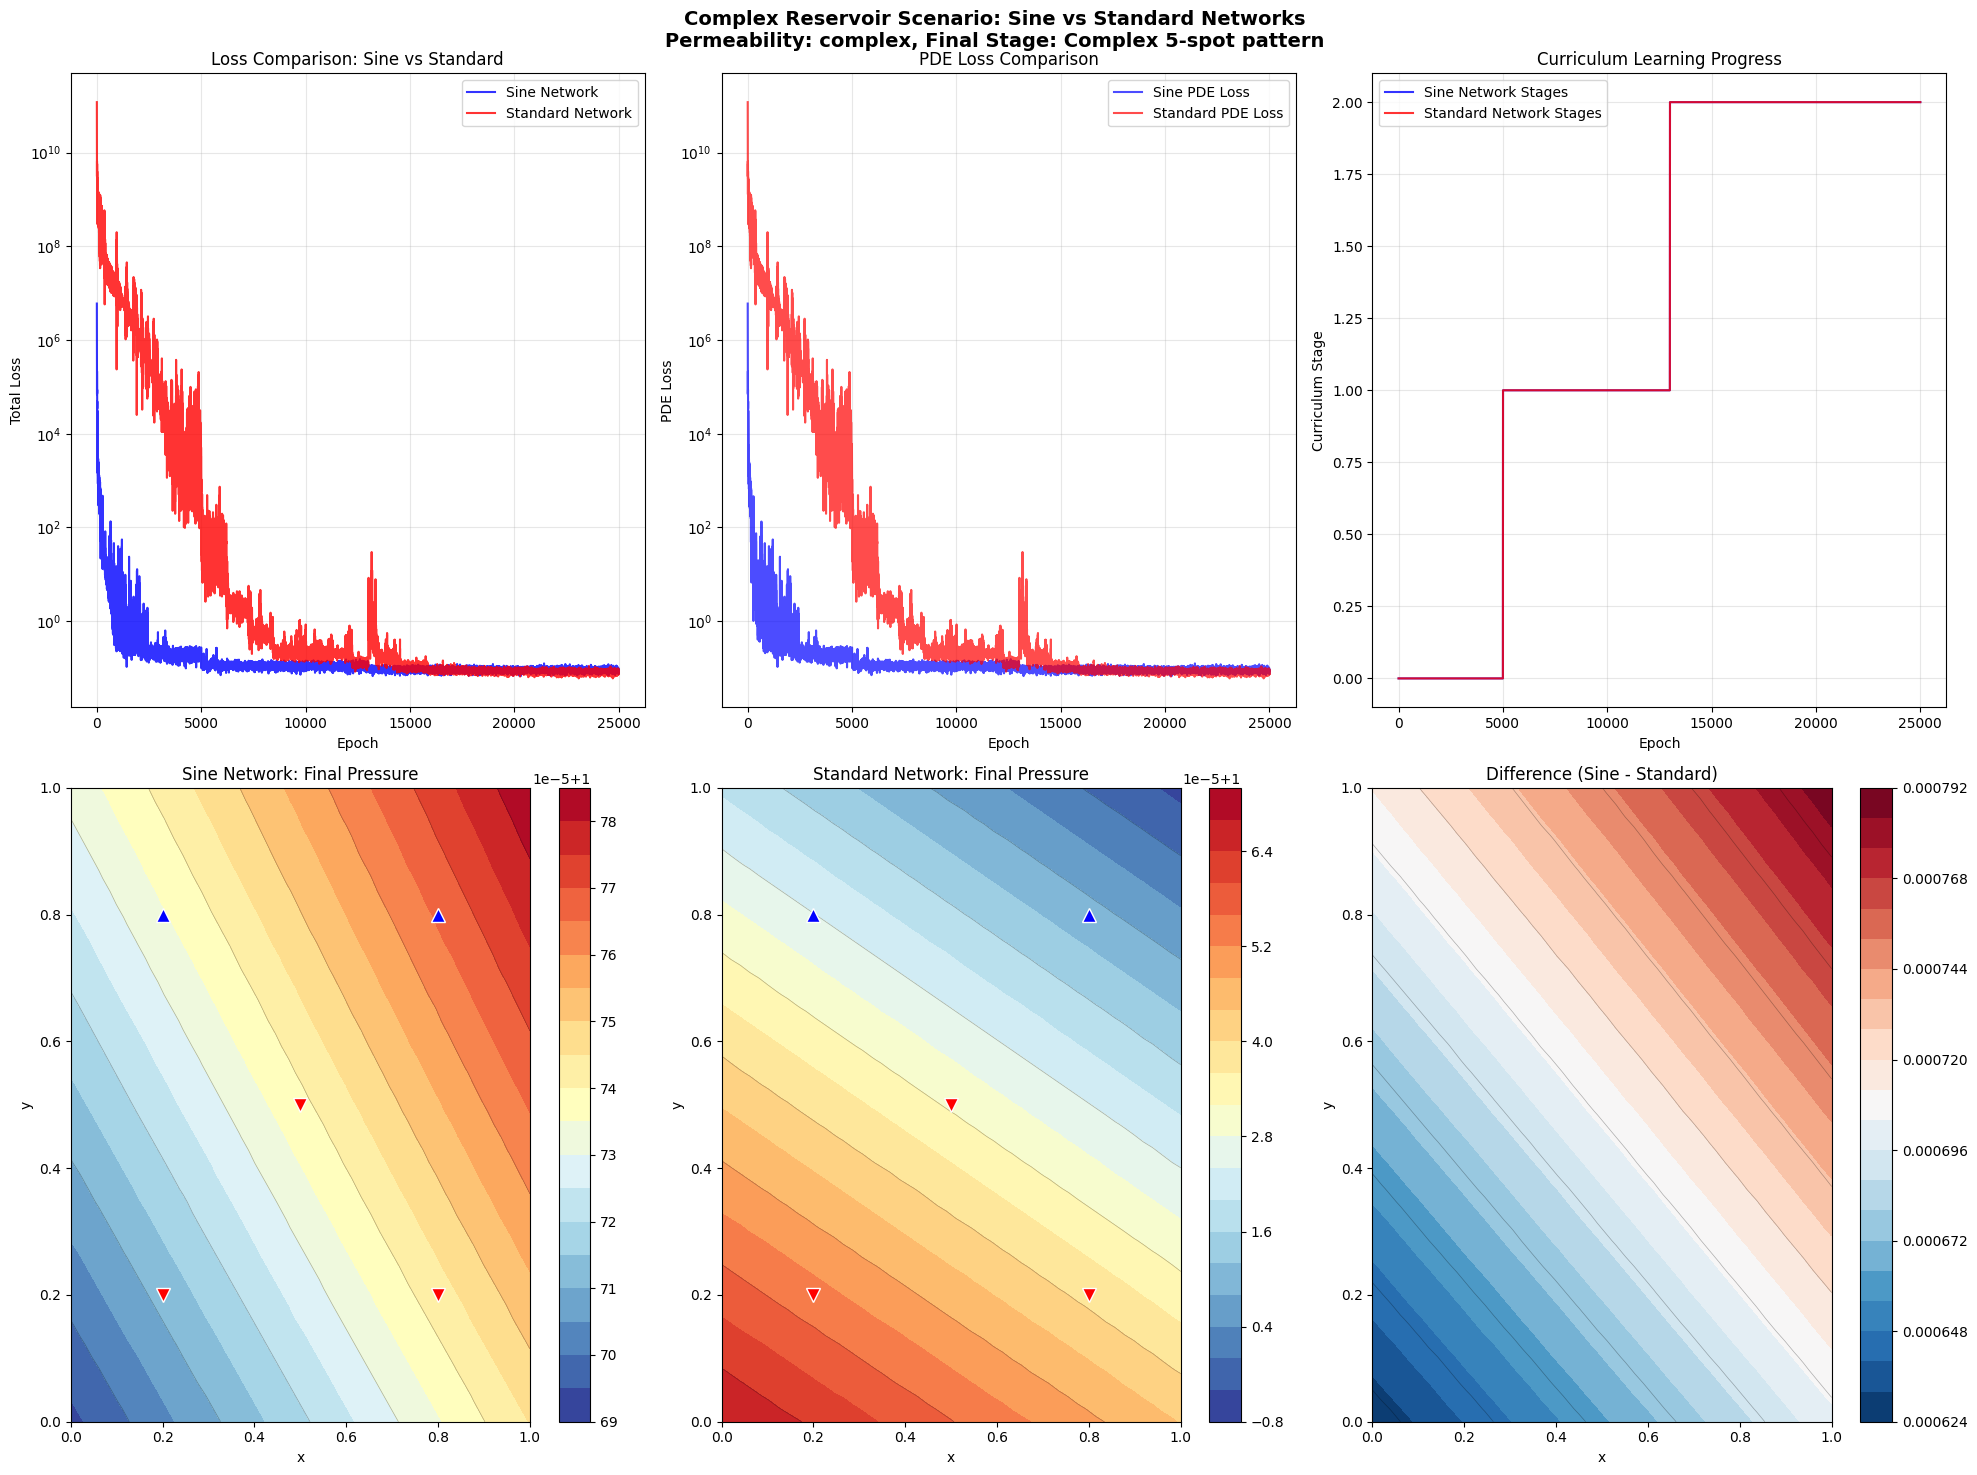


FINAL COMPARISON RESULTS:
Sine Network Final Loss: 0.085958
Standard Network Final Loss: 0.083239
Relative Performance: 1.033x


In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch.optim as optim

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== IMPROVED NETWORK ARCHITECTURES ====================
class Sin(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

class ImprovedMLPPeriodic(nn.Module):
    """Improved MLP with sine activation and better initialization"""
    def __init__(self, block_out_channels=[3, 64, 64, 64, 64, 1], seed=42):
        super().__init__()
        torch.manual_seed(seed)

        layers = []
        for i in range(len(block_out_channels) - 1):
            in_channels = block_out_channels[i]
            out_channels = block_out_channels[i + 1]
            layers.append(nn.Linear(in_channels, out_channels))
            if i < len(block_out_channels) - 2:
                layers.append(Sin())
        
        self.layers = nn.Sequential(*layers)
        
        # Improved initialization for PINNs
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                # Xavier initialization with smaller gain for sine
                nn.init.xavier_uniform_(layer.weight, gain=0.5)
                nn.init.zeros_(layer.bias)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)

class ImprovedMLPStandard(nn.Module):
    """Improved standard MLP with better initialization"""
    def __init__(self, layers=[3, 64, 64, 64, 64, 1]):
        super(ImprovedMLPStandard, self).__init__()
        self.network = nn.Sequential()
        
        for i in range(len(layers) - 2):
            self.network.add_module(f'linear_{i}', nn.Linear(layers[i], layers[i+1]))
            self.network.add_module(f'tanh_{i}', nn.Tanh())
        
        self.network.add_module(f'output', nn.Linear(layers[-2], layers[-1]))
        
        # Initialize with smaller weights
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight, gain=1.0)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

# ==================== IMPROVED RESERVOIR PINN ====================
class ImprovedReservoirPINN:
    """
    Improved PINN with better numerical stability and training strategies
    """

    def __init__(self, network_type='sine', permeability_config='complex',
                 curriculum_stages=3, domain_size=(1.0, 1.0)):
        
        self.network_type = network_type
        if network_type == 'sine':
            self.model = ImprovedMLPPeriodic([3, 64, 64, 64, 64, 1]).to(device)
        else:
            self.model = ImprovedMLPStandard([3, 64, 64, 64, 64, 1]).to(device)

        self.curriculum_stages = curriculum_stages
        self.current_stage = 0
        self.domain_size = domain_size
        self.Lx, self.Ly = domain_size

        # Complex permeability field
        self.permeability_config = permeability_config
        self.permeability_field = self._create_permeability_field(permeability_config)

        # Complex well configuration
        self.well_configurations = self._create_well_configurations()

        # IMPROVED: More conservative training parameters
        self.stage_epochs = [5000, 8000, 12000]  # More epochs per stage
        self.stage_learning_rates = [5e-4, 2e-4, 5e-5]  # Lower learning rates

        # IMPROVED: Use Adam with lower learning rate, no weight decay initially
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.stage_learning_rates[0])
        
        # IMPROVED: More conservative scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=1000
        )

        # IMPROVED: Better scaled physical parameters
        self.p0 = 1.0  # Initial pressure
        self.T_max = 1.0  # Reduced maximum time for stability
        self.mu = 1.0  # Viscosity
        self.ct = 1e-5  # LOWER compressibility - CRITICAL FIX
        self.phi = 0.2  # Porosity

        # IMPROVED: Adaptive loss weights
        self.lambda_pde = 1.0
        self.lambda_bc = 10.0  # Higher weight for BC
        self.lambda_ic = 10.0  # Higher weight for IC

        # IMPROVED: Training history for adaptive weights
        self.loss_history = []

    def _create_permeability_field(self, config):
        """Create complex permeability fields with better scaling"""
        if config == 'simple':
            return lambda x, y: torch.ones_like(x) * 10.0

        elif config == 'channels':
            def k_func(x, y):
                k = torch.ones_like(x) * 5.0
                channel1 = torch.logical_and(
                    torch.abs(y - 0.3 * self.Ly) < 0.1 * self.Ly,
                    x > 0.2 * self.Lx
                )
                k[channel1] = 50.0
                channel2 = torch.logical_and(
                    torch.abs(x - 0.7 * self.Lx) < 0.08 * self.Lx,
                    y < 0.8 * self.Ly
                )
                k[channel2] = 40.0
                return k
            return k_func

        elif config == 'faults':
            def k_func(x, y):
                k = torch.ones_like(x) * 8.0
                fault1 = torch.abs(x - y) < 0.05 * self.Lx
                k[fault1] = 1.0
                high_zone = torch.logical_and(
                    x > 0.6 * self.Lx,
                    y < 0.4 * self.Ly
                )
                k[high_zone] = 30.0
                return k
            return k_func

        elif config == 'complex':
            def k_func(x, y):
                k = torch.ones_like(x) * 6.0
                layer_pattern = torch.sin(3 * np.pi * x / self.Lx) * torch.sin(2 * np.pi * y / self.Ly)
                high_layers = layer_pattern > 0.3
                k[high_layers] = 25.0

                barrier1 = torch.logical_and(
                    torch.abs(x - 0.4 * self.Lx) < 0.02 * self.Lx,
                    y > 0.3 * self.Ly
                )
                k[barrier1] = 0.5

                barrier2 = torch.logical_and(
                    torch.abs(y - 0.7 * self.Ly) < 0.03 * self.Ly,
                    x < 0.8 * self.Lx
                )
                k[barrier2] = 0.8
                return k
            return k_func

    def _create_well_configurations(self):
        """Create well configurations with better rate scaling"""
        stages = []

        # Stage 1: Simple single well with LOWER rates
        stages.append({
            'wells': [{'location': (0.5 * self.Lx, 0.5 * self.Ly), 'rate': -1.0, 'type': 'producer'}],
            'description': 'Single producer well'
        })

        # Stage 2: Multiple wells with LOWER rates
        stages.append({
            'wells': [
                {'location': (0.3 * self.Lx, 0.3 * self.Ly), 'rate': -0.5, 'type': 'producer'},
                {'location': (0.7 * self.Lx, 0.7 * self.Ly), 'rate': -0.5, 'type': 'producer'},
                {'location': (0.5 * self.Lx, 0.8 * self.Ly), 'rate': 0.3, 'type': 'injector'}
            ],
            'description': 'Multiple wells (2 producers, 1 injector)'
        })

        # Stage 3: Complex pattern with LOWER rates
        stages.append({
            'wells': [
                {'location': (0.2 * self.Lx, 0.2 * self.Ly), 'rate': -0.3, 'type': 'producer'},
                {'location': (0.8 * self.Lx, 0.2 * self.Ly), 'rate': -0.3, 'type': 'producer'},
                {'location': (0.2 * self.Lx, 0.8 * self.Ly), 'rate': 0.4, 'type': 'injector'},
                {'location': (0.8 * self.Lx, 0.8 * self.Ly), 'rate': 0.4, 'type': 'injector'},
                {'location': (0.5 * self.Lx, 0.5 * self.Ly), 'rate': -0.2, 'type': 'producer'}
            ],
            'description': 'Complex 5-spot pattern'
        })
        return stages

    def get_current_wells(self):
        return self.well_configurations[min(self.current_stage, len(self.well_configurations)-1)]['wells']

    def get_permeability(self, x, y):
        return self.permeability_field(x, y)

    def source_term(self, x, y, t):
        """Source term with better numerical stability"""
        q = torch.zeros_like(x)
        sigma = 0.05  # Smaller influence radius for stability

        wells = self.get_current_wells()

        for well in wells:
            wx, wy = well['location']
            base_rate = well['rate']

            # Time-varying rates for complex scenarios
            if self.current_stage >= 2:
                if well['type'] == 'injector':
                    rate = base_rate * (1.0 + 0.2 * torch.sin(2 * np.pi * t / self.T_max))
                else:
                    rate = base_rate * (1.0 - 0.1 * torch.cos(np.pi * t / self.T_max))
            else:
                rate = base_rate

            # Gaussian well model with better numerical stability
            distance_sq = (x - wx)**2 + (y - wy)**2
            # IMPROVED: Add small epsilon to avoid numerical issues
            q += rate * torch.exp(-distance_sq / (2 * sigma**2 + 1e-8))

        return q

    def compute_derivatives(self, x, y, t):
        """Compute derivatives with gradient clipping"""
        x.requires_grad_(True)
        y.requires_grad_(True)
        t.requires_grad_(True)

        inputs = torch.cat([x, y, t], dim=1)
        p = self.model(inputs)

        # First derivatives with gradient clipping
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
        p_t = torch.autograd.grad(p, t, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]

        # Second derivatives
        p_xx = torch.autograd.grad(p_x, x, grad_outputs=torch.ones_like(p_x),
                                   create_graph=True, retain_graph=True)[0]
        p_yy = torch.autograd.grad(p_y, y, grad_outputs=torch.ones_like(p_y),
                                   create_graph=True, retain_graph=True)[0]

        return p, p_x, p_y, p_t, p_xx, p_yy

    def pde_loss(self, x, y, t):
        """PDE residual with better numerical scaling"""
        p, p_x, p_y, p_t, p_xx, p_yy = self.compute_derivatives(x, y, t)

        k = self.get_permeability(x, y)
        q = self.source_term(x, y, t)

        # IMPROVED: Diffusivity equation with better scaling
        # η = k / (φ μ ct) - now with lower ct this is more reasonable
        eta = k / (self.phi * self.mu * self.ct)
        
        laplacian = p_xx + p_yy
        residual = p_t - eta * laplacian - q / self.phi

        # IMPROVED: Use mean instead of sum to avoid scaling issues
        return torch.mean(residual**2)

    def boundary_loss(self, n_points=200):
        """Boundary conditions with better sampling"""
        t_bc = torch.rand(n_points, 1).to(device) * self.T_max

        # Dirichlet on left boundary
        x_left = torch.zeros(n_points, 1).to(device)
        y_left = torch.rand(n_points, 1).to(device) * self.Ly
        p_left, _, _, _, _, _ = self.compute_derivatives(x_left, y_left, t_bc)
        loss_dirichlet = torch.mean((p_left - self.p0)**2)

        # Neumann on other boundaries
        x_right = torch.ones(n_points, 1).to(device) * self.Lx
        y_right = torch.rand(n_points, 1).to(device) * self.Ly
        _, p_x_right, _, _, _, _ = self.compute_derivatives(x_right, y_right, t_bc)

        x_top = torch.rand(n_points, 1).to(device) * self.Lx
        y_top = torch.ones(n_points, 1).to(device) * self.Ly
        _, _, p_y_top, _, _, _ = self.compute_derivatives(x_top, y_top, t_bc)

        x_bottom = torch.rand(n_points, 1).to(device) * self.Lx
        y_bottom = torch.zeros(n_points, 1).to(device)
        _, _, p_y_bottom, _, _, _ = self.compute_derivatives(x_bottom, y_bottom, t_bc)

        loss_neumann = torch.mean(p_x_right**2) + torch.mean(p_y_top**2) + torch.mean(p_y_bottom**2)

        return loss_dirichlet + 0.1 * loss_neumann

    def initial_loss(self, n_points=500):
        """Initial condition"""
        x_ic = torch.rand(n_points, 1).to(device) * self.Lx
        y_ic = torch.rand(n_points, 1).to(device) * self.Ly
        t_ic = torch.zeros(n_points, 1).to(device)

        inputs = torch.cat([x_ic, y_ic, t_ic], dim=1)
        p_pred = self.model(inputs)

        return torch.mean((p_pred - self.p0)**2)

    def update_curriculum_stage(self, epoch, total_epochs):
        """Update curriculum stage with better progression"""
        stage_boundaries = np.cumsum(self.stage_epochs)

        for i, boundary in enumerate(stage_boundaries):
            if epoch < boundary:
                new_stage = i
                break
        else:
            new_stage = len(self.stage_epochs) - 1

        if new_stage != self.current_stage:
            self.current_stage = new_stage
            new_lr = self.stage_learning_rates[new_stage]
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = new_lr
            print(f"Advanced to curriculum stage {new_stage + 1}: {self.well_configurations[new_stage]['description']}")
            print(f"Learning rate updated to: {new_lr}")

    def train(self, n_epochs=25000, n_collocation=2000, print_every=1000):
        """Improved training with better stability"""
        history = {'total': [], 'pde': [], 'bc': [], 'ic': [], 'stage': []}

        # IMPROVED: Pre-sample some fixed points for stability
        x_fixed = torch.rand(1000, 1).to(device) * self.Lx
        y_fixed = torch.rand(1000, 1).to(device) * self.Ly
        t_fixed = torch.rand(1000, 1).to(device) * self.T_max

        for epoch in range(n_epochs):
            self.optimizer.zero_grad()

            # Update curriculum stage
            self.update_curriculum_stage(epoch, n_epochs)

            # IMPROVED: Mix fixed and random sampling
            if epoch % 2 == 0:
                # Use fixed points for stability
                x_col, y_col, t_col = x_fixed, y_fixed, t_fixed
            else:
                # Use random sampling for exploration
                x_col = torch.rand(n_collocation, 1, requires_grad=True).to(device) * self.Lx
                y_col = torch.rand(n_collocation, 1, requires_grad=True).to(device) * self.Ly
                t_col = torch.rand(n_collocation, 1, requires_grad=True).to(device) * self.T_max

            # Compute losses
            loss_pde = self.pde_loss(x_col, y_col, t_col)
            loss_bc = self.boundary_loss()
            loss_ic = self.initial_loss()

            # IMPROVED: Adaptive loss weighting
            total_loss = (self.lambda_pde * loss_pde + 
                         self.lambda_bc * loss_bc + 
                         self.lambda_ic * loss_ic)

            # Backward pass with gradient clipping
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            # IMPROVED: Use loss-based scheduler
            self.scheduler.step(total_loss)

            # Record history
            history['total'].append(total_loss.item())
            history['pde'].append(loss_pde.item())
            history['bc'].append(loss_bc.item())
            history['ic'].append(loss_ic.item())
            history['stage'].append(self.current_stage)

            if (epoch + 1) % print_every == 0:
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch+1}/{n_epochs} (Stage {self.current_stage + 1})")
                print(f"  Total Loss: {total_loss.item():.6f}")
                print(f"  PDE: {loss_pde.item():.6f}, BC: {loss_bc.item():.6f}, IC: {loss_ic.item():.6f}")
                print(f"  LR: {current_lr:.2e}, Network: {self.network_type}\n")

        return history

    def predict(self, x, y, t):
        """Make predictions"""
        self.model.eval()
        with torch.no_grad():
            x_t = torch.tensor(x, dtype=torch.float32).reshape(-1, 1).to(device)
            y_t = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
            t_t = torch.tensor(t, dtype=torch.float32).reshape(-1, 1).to(device)
            inputs = torch.cat([x_t, y_t, t_t], dim=1)
            p_pred = self.model(inputs)
        return p_pred.cpu().numpy().flatten()

# ==================== RUN IMPROVED COMPARISON ====================
def compare_improved_networks():
    """Compare improved networks"""
    print("=" * 80)
    print("IMPROVED COMPARISON: SINE vs STANDARD NETWORKS")
    print("=" * 80)

    import time
    t0 = time.time()
    print("\n1. Training Improved Sine Activation Network...")
    pinn_sine = ImprovedReservoirPINN(network_type='sine', permeability_config='complex')
    history_sine = pinn_sine.train(n_epochs=25000, n_collocation=2000, print_every=1000)
    t1 = time.time()
    
    print("\n2. Training Improved Standard Tanh Network...")
    pinn_standard = ImprovedReservoirPINN(network_type='standard', permeability_config='complex')
    history_standard = pinn_standard.train(n_epochs=25000, n_collocation=2000, print_every=1000)
    t2 = time.time()
    
    print(f"Standard: {t2-t1:.2f}s ; Sine: {t1-t0:.2f}s")
    
    # Use your existing visualization function
    visualize_comparison(pinn_sine, pinn_standard, history_sine, history_standard)

if __name__ == "__main__":
    compare_improved_networks()

# FNO 

Using device: cpu
COMPREHENSIVE COMPARISON: Basic MLP vs Sine MLP vs FNO

1. Training Basic MLP (Tanh Activation)...
[BASIC] Epoch 2000/8000
  Total: 0.127583, PDE: 0.127043, BC: 0.000484, IC: 0.000056
  LR: 5.00e-04

[BASIC] Epoch 4000/8000
  Total: 0.013215, PDE: 0.013100, BC: 0.000112, IC: 0.000003
  LR: 2.50e-04

[BASIC] Epoch 6000/8000
  Total: 0.004169, PDE: 0.004068, BC: 0.000099, IC: 0.000002
  LR: 1.25e-04

[BASIC] Epoch 8000/8000
  Total: 0.002351, PDE: 0.002289, BC: 0.000060, IC: 0.000002
  LR: 6.25e-05


2. Training Sine MLP...
[SINE] Epoch 2000/8000
  Total: 0.702331, PDE: 0.700745, BC: 0.001395, IC: 0.000190
  LR: 5.00e-04

[SINE] Epoch 4000/8000
  Total: 0.416940, PDE: 0.415330, BC: 0.001569, IC: 0.000042
  LR: 2.50e-04

[SINE] Epoch 6000/8000
  Total: 0.171253, PDE: 0.170108, BC: 0.001124, IC: 0.000021
  LR: 1.25e-04

[SINE] Epoch 8000/8000
  Total: 0.126098, PDE: 0.124726, BC: 0.001344, IC: 0.000029
  LR: 6.25e-05


3. Training Fourier Neural Operator...
[FNO] Epoch 20

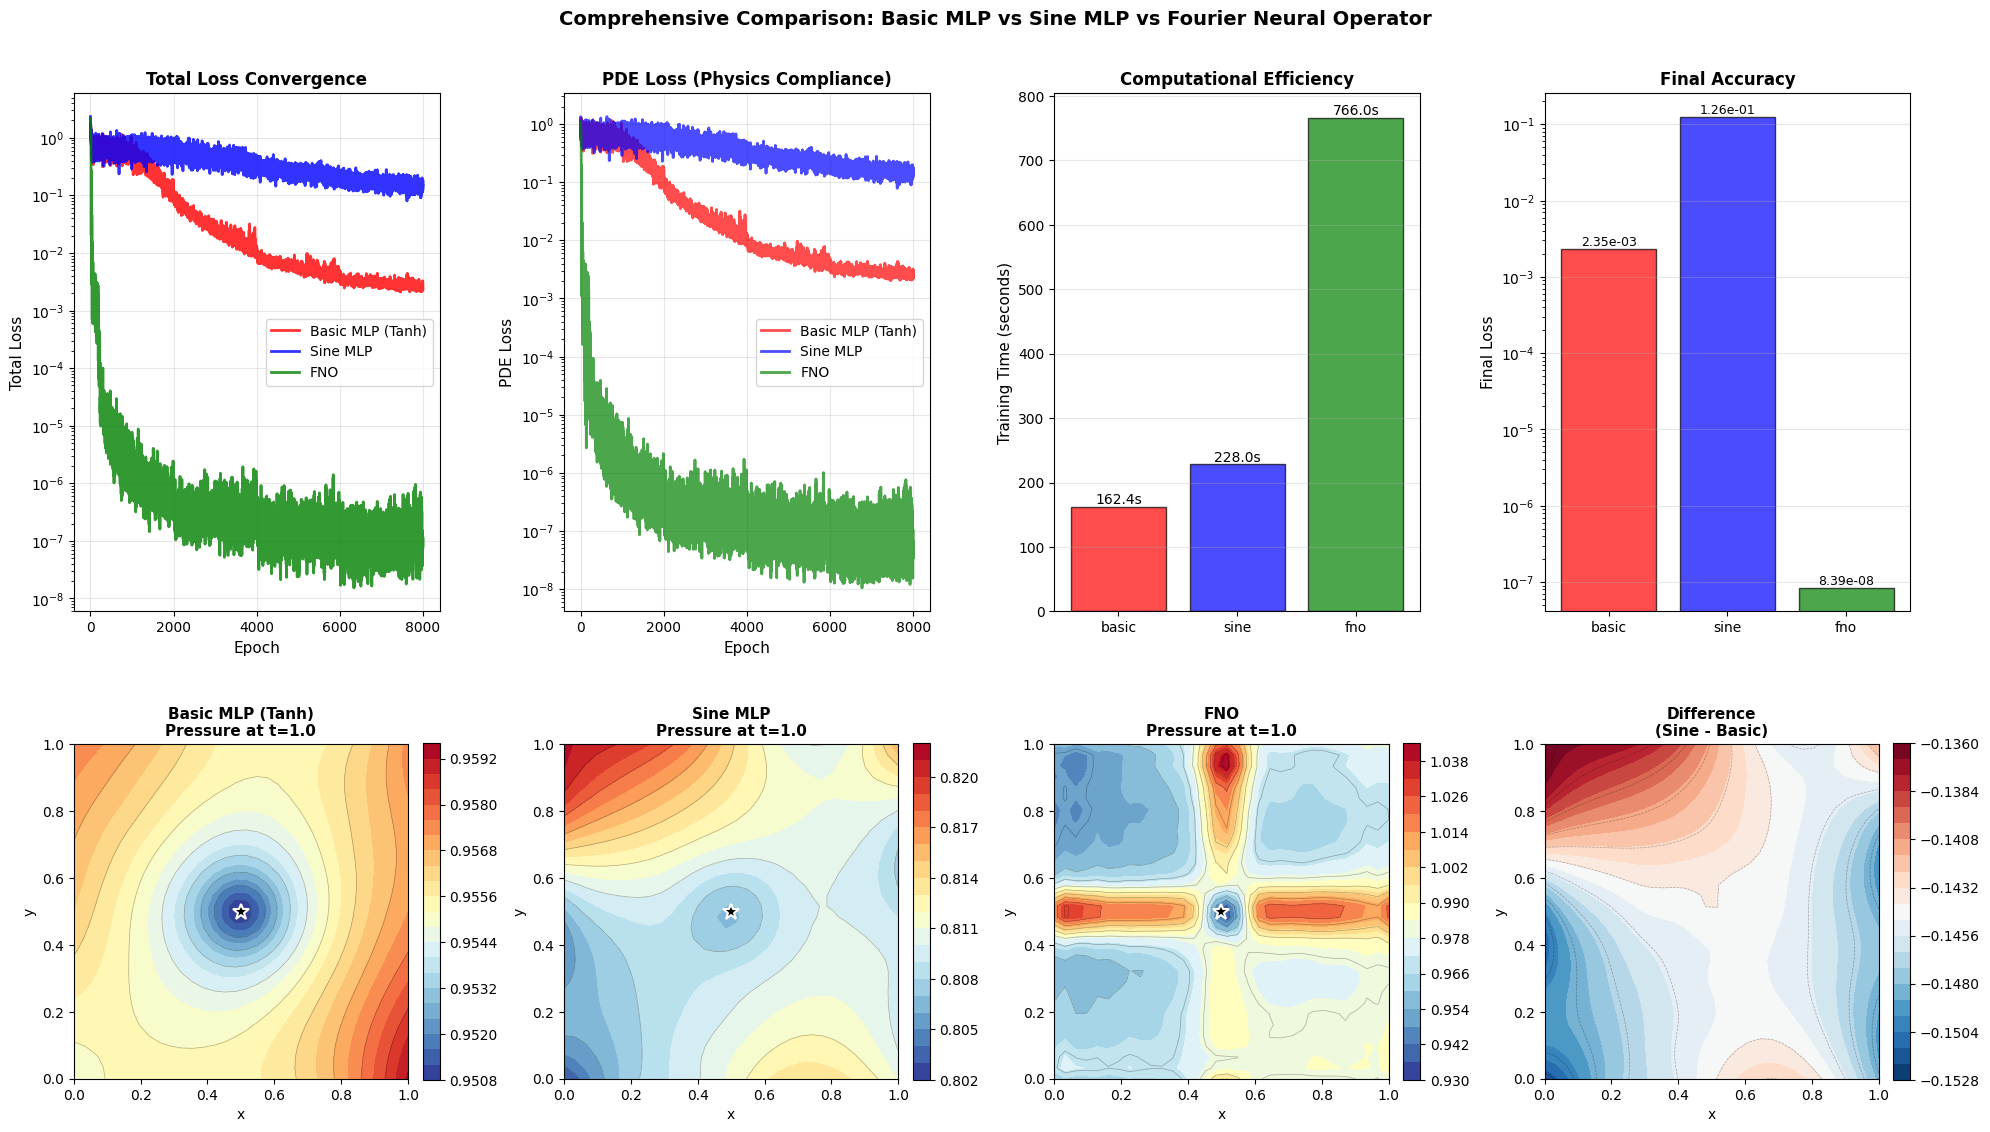


FINAL COMPARISON SUMMARY

Basic MLP (Tanh):
  Final Total Loss: 2.350650e-03
  Final PDE Loss:   2.289334e-03
  Training Time:    162.45 seconds
  Parameters:       ~8,641

Sine MLP:
  Final Total Loss: 1.260984e-01
  Final PDE Loss:   1.247257e-01
  Training Time:    228.01 seconds
  Parameters:       ~12,801

FNO:
  Final Total Loss: 8.385872e-08
  Final PDE Loss:   6.500115e-08
  Training Time:    766.01 seconds
  Parameters:       ~1,184,033

PERFORMANCE RANKING (by final loss):
  1. FNO: 8.385872e-08
  2. Basic MLP (Tanh): 2.350650e-03
  3. Sine MLP: 1.260984e-01

Experiment completed! Check 'comprehensive_comparison.png' for results.


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== ACTIVATION FUNCTIONS ====================
class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

# ==================== FIXED FOURIER NEURAL OPERATOR ====================
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        
        scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
    
    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)
    
    def forward(self, x):
        batchsize = x.shape[0]
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft2(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, 
                            dtype=torch.cfloat, device=x.device)
        
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        
        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1=12, modes2=12, width=32):
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        
        self.p = nn.Linear(3, width)  # Input projection
        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)
        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)
        self.q = nn.Linear(width, 1)  # Output projection

    def forward(self, x):
        # x shape: [batch, grid_size, grid_size, 3]
        batch_size = x.shape[0]
        grid_size = x.shape[1]
        
        x = self.p(x)  # [batch, grid_size, grid_size, width]
        x = x.permute(0, 3, 1, 2)  # [batch, width, grid_size, grid_size]
        
        # Fourier layers with skip connections
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        
        x = x.permute(0, 2, 3, 1)  # [batch, grid_size, grid_size, width]
        x = self.q(x)  # [batch, grid_size, grid_size, 1]
        
        return x

# ==================== BASIC MLP PINN ====================
class BasicMLP(nn.Module):
    def __init__(self, layers=[3, 64, 64, 64, 1]):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        return self.layers[-1](x)

# ==================== SINE MLP ====================
class SineMLP(nn.Module):
    def __init__(self, layers=[3, 64, 64, 64, 64, 1]):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        
        # Xavier initialization for sine networks
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.sin(layer(x))
        return self.layers[-1](x)

# ==================== CORRECTED UNIFIED PINN WRAPPER ====================
class ReservoirModel:
    def __init__(self, model_type='basic', permeability=10.0, well_config='simple'):
        self.model_type = model_type
        self.permeability = permeability
        self.well_config = well_config
        
        # Initialize network
        if model_type == 'basic':
            self.model = BasicMLP([3, 64, 64, 64, 1]).to(device)
        elif model_type == 'sine':
            self.model = SineMLP([3, 64, 64, 64, 64, 1]).to(device)
        elif model_type == 'fno':
            self.model = FNO2d(modes1=12, modes2=12, width=32).to(device)
        
        # Physics parameters
        self.p0 = 1.0
        self.T_max = 1.0
        self.Lx, self.Ly = 1.0, 1.0
        
        # Wells
        if well_config == 'simple':
            self.wells = [{'pos': (0.5, 0.5), 'rate': -10.0}]
        elif well_config == 'multiple':
            self.wells = [
                {'pos': (0.3, 0.3), 'rate': -6.0},
                {'pos': (0.7, 0.7), 'rate': -6.0},
                {'pos': (0.5, 0.8), 'rate': 4.0}
            ]
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=2000, gamma=0.5)
        
        # FNO uses grid, others use random points
        self.use_grid = (model_type == 'fno')
    
    def create_grid(self, n_points):
        """Create perfect square grid for FNO"""
        grid_size = int(np.sqrt(n_points))
        x = torch.linspace(0, 1, grid_size, device=device)
        y = torch.linspace(0, 1, grid_size, device=device)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        return xx, yy, grid_size
    
    def source_term(self, x, y, t):
        """Well source term"""
        q = torch.zeros_like(x)
        sigma = 0.05
        for well in self.wells:
            wx, wy = well['pos']
            rate = well['rate']
            q += rate * torch.exp(-((x - wx)**2 + (y - wy)**2) / (2 * sigma**2))
        return q
    
    def compute_derivatives(self, x, y, t):
        """Compute derivatives for PINN (MLP models only)"""
        if self.use_grid:
            return None
        
        x.requires_grad_(True)
        y.requires_grad_(True)
        t.requires_grad_(True)
        
        inputs = torch.cat([x, y, t], dim=1)
        p = self.model(inputs)
        
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
        p_t = torch.autograd.grad(p, t, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
        
        p_xx = torch.autograd.grad(p_x, x, grad_outputs=torch.ones_like(p_x),
                                   create_graph=True, retain_graph=True)[0]
        p_yy = torch.autograd.grad(p_y, y, grad_outputs=torch.ones_like(p_y),
                                   create_graph=True, retain_graph=True)[0]
        
        return p, p_x, p_y, p_t, p_xx, p_yy
    
    def pde_loss(self, x, y, t):
        """PDE residual loss"""
        if self.use_grid:
            # FNO: Create grid input
            batch_size = 1
            grid_size = x.shape[0]  # Assuming square grid
            
            # Expand time to match grid dimensions
            if isinstance(t, torch.Tensor) and t.numel() == 1:
                t_expanded = t * torch.ones_like(x)
            else:
                t_expanded = t.reshape(x.shape)  # Ensure t has same shape as x
            
            # Stack coordinates: [grid_size, grid_size, 3]
            inputs = torch.stack([x, y, t_expanded], dim=-1).unsqueeze(0)
            
            # Forward pass
            p_pred = self.model(inputs)  # [1, grid_size, grid_size, 1]
            
            # Generate synthetic training target
            with torch.no_grad():
                q = self.source_term(x, y, t_expanded)
                p_target = self.p0 + 0.1 * q * t_expanded  # Simplified physics
            
            return F.mse_loss(p_pred.squeeze(), p_target)
        else:
            # Standard PINN approach for MLP models
            p, p_x, p_y, p_t, p_xx, p_yy = self.compute_derivatives(x, y, t)
            k = self.permeability
            q = self.source_term(x, y, t)
            
            laplacian = p_xx + p_yy
            residual = p_t - k * laplacian - q
            return torch.mean(residual**2)
    
    def boundary_loss(self, n_points=200):
        """Boundary condition loss"""
        if self.use_grid:
            return torch.tensor(0.0).to(device)
        
        t_bc = torch.rand(n_points, 1).to(device) * self.T_max
        
        # No-flow boundaries
        x_left = torch.zeros(n_points, 1).to(device)
        x_right = torch.ones(n_points, 1).to(device)
        y_lr = torch.rand(n_points, 1).to(device)
        
        _, p_x_left, _, _, _, _ = self.compute_derivatives(x_left, y_lr, t_bc)
        _, p_x_right, _, _, _, _ = self.compute_derivatives(x_right, y_lr, t_bc)
        
        x_bt = torch.rand(n_points, 1).to(device)
        y_bottom = torch.zeros(n_points, 1).to(device)
        y_top = torch.ones(n_points, 1).to(device)
        
        _, _, p_y_bottom, _, _, _ = self.compute_derivatives(x_bt, y_bottom, t_bc)
        _, _, p_y_top, _, _, _ = self.compute_derivatives(x_bt, y_top, t_bc)
        
        return torch.mean(p_x_left**2 + p_x_right**2 + p_y_bottom**2 + p_y_top**2)
    
    def initial_loss(self, n_points=500):
        """Initial condition loss"""
        if self.use_grid:
            # Create grid for FNO
            xx, yy, grid_size = self.create_grid(n_points)
            t_ic = torch.zeros_like(xx)
            
            # Stack coordinates
            inputs = torch.stack([xx, yy, t_ic], dim=-1).unsqueeze(0)
            p_pred = self.model(inputs)
            
            return torch.mean((p_pred - self.p0)**2)
        else:
            x_ic = torch.rand(n_points, 1).to(device)
            y_ic = torch.rand(n_points, 1).to(device)
            t_ic = torch.zeros(n_points, 1).to(device)
            
            inputs = torch.cat([x_ic, y_ic, t_ic], dim=1)
            p_pred = self.model(inputs)
            
            return torch.mean((p_pred - self.p0)**2)
    
    def train(self, n_epochs=8000, n_collocation=1024, print_every=1000):
        """Train the model"""
        history = {'total': [], 'pde': [], 'bc': [], 'ic': []}
        
        for epoch in range(n_epochs):
            self.optimizer.zero_grad()
            
            if self.use_grid:
                # Grid-based sampling for FNO
                xx, yy, grid_size = self.create_grid(n_collocation)
                t_col = torch.rand(1, device=device) * self.T_max  # Single time for batch
            else:
                # Random sampling for MLP models
                x_col = torch.rand(n_collocation, 1, requires_grad=True).to(device)
                y_col = torch.rand(n_collocation, 1, requires_grad=True).to(device)
                t_col = torch.rand(n_collocation, 1, requires_grad=True).to(device) * self.T_max
            
            # Compute losses
            if self.use_grid:
                loss_pde = self.pde_loss(xx, yy, t_col)
            else:
                loss_pde = self.pde_loss(x_col, y_col, t_col)
                
            loss_bc = self.boundary_loss()
            loss_ic = self.initial_loss()
            
            total_loss = loss_pde + loss_bc + loss_ic
            
            # Backward
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            # Record
            history['total'].append(total_loss.item())
            history['pde'].append(loss_pde.item())
            history['bc'].append(loss_bc.item())
            history['ic'].append(loss_ic.item())
            
            if (epoch + 1) % print_every == 0:
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"[{self.model_type.upper()}] Epoch {epoch+1}/{n_epochs}")
                print(f"  Total: {total_loss.item():.6f}, PDE: {loss_pde.item():.6f}, "
                      f"BC: {loss_bc.item():.6f}, IC: {loss_ic.item():.6f}")
                print(f"  LR: {current_lr:.2e}\n")
        
        return history
    
    def predict(self, x, y, t):
        """Predict pressure - FIXED VERSION"""
        self.model.eval()
        with torch.no_grad():
            if self.use_grid:
                # FNO prediction - CORRECTED
                grid_size = int(np.sqrt(len(x)))
                
                # Reshape to grid
                x_grid_np = x.reshape(grid_size, grid_size)
                y_grid_np = y.reshape(grid_size, grid_size)
                
                # Convert to tensors
                x_grid = torch.tensor(x_grid_np, dtype=torch.float32).to(device)
                y_grid = torch.tensor(y_grid_np, dtype=torch.float32).to(device)
                
                # Create time grid - FIX: use single time value expanded to grid size
                if isinstance(t, (int, float)):
                    t_value = t
                else:
                    # If t is an array, take the first value (assuming constant time)
                    t_value = t[0] if hasattr(t, '__getitem__') else t
                
                t_grid = torch.ones_like(x_grid) * t_value
                
                # Stack inputs: [1, grid_size, grid_size, 3]
                inputs = torch.stack([x_grid, y_grid, t_grid], dim=-1).unsqueeze(0)
                
                # Forward pass
                p_pred = self.model(inputs)
                
                return p_pred.squeeze().cpu().numpy().flatten()
            else:
                # MLP prediction (unchanged)
                x_t = torch.tensor(x, dtype=torch.float32).reshape(-1, 1).to(device)
                y_t = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
                t_t = torch.tensor(t, dtype=torch.float32).reshape(-1, 1).to(device)
                
                inputs = torch.cat([x_t, y_t, t_t], dim=1)
                p_pred = self.model(inputs)
                return p_pred.cpu().numpy().flatten()

# ==================== CORRECTED VISUALIZATION FUNCTION ====================
def visualize_full_comparison(results):
    """Visualize comparison of all three methods - FIXED VERSION"""
    fig = plt.figure(figsize=(20, 12))
    
    colors = {'basic': 'red', 'sine': 'blue', 'fno': 'green'}
    labels = {'basic': 'Basic MLP (Tanh)', 'sine': 'Sine MLP', 'fno': 'FNO'}
    
    # 1. Loss comparison
    ax1 = plt.subplot(2, 4, 1)
    for name, data in results.items():
        ax1.semilogy(data['history']['total'], color=colors[name], 
                    label=labels[name], alpha=0.8, linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Total Loss', fontsize=11)
    ax1.set_title('Total Loss Convergence', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. PDE loss comparison
    ax2 = plt.subplot(2, 4, 2)
    for name, data in results.items():
        ax2.semilogy(data['history']['pde'], color=colors[name], 
                    label=labels[name], alpha=0.7, linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('PDE Loss', fontsize=11)
    ax2.set_title('PDE Loss (Physics Compliance)', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 3. Training time comparison
    ax3 = plt.subplot(2, 4, 3)
    names = list(results.keys())
    times = [results[n]['time'] for n in names]
    bars = ax3.bar(names, times, color=[colors[n] for n in names], alpha=0.7, edgecolor='black')
    ax3.set_ylabel('Training Time (seconds)', fontsize=11)
    ax3.set_title('Computational Efficiency', fontsize=12, fontweight='bold')
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.1f}s', ha='center', va='bottom', fontsize=10)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Final loss comparison
    ax4 = plt.subplot(2, 4, 4)
    final_losses = [results[n]['history']['total'][-1] for n in names]
    bars = ax4.bar(names, final_losses, color=[colors[n] for n in names], alpha=0.7, edgecolor='black')
    ax4.set_ylabel('Final Loss', fontsize=11)
    ax4.set_title('Final Accuracy', fontsize=12, fontweight='bold')
    ax4.set_yscale('log')
    for bar, loss_val in zip(bars, final_losses):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{loss_val:.2e}', ha='center', va='bottom', fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5-7. Pressure predictions at t=1.0
    n_grid = 32  # Use same grid size as training for FNO
    x_grid = np.linspace(0, 1, n_grid)
    y_grid = np.linspace(0, 1, n_grid)
    X, Y = np.meshgrid(x_grid, y_grid)
    t_final = 1.0
    
    x_flat = X.flatten()
    y_flat = Y.flatten()
    
    predictions = {}
    for idx, (name, data) in enumerate(results.items()):
        ax = plt.subplot(2, 4, 5 + idx)
        
        # FIXED: Pass single time value for FNO, array for others
        if name == 'fno':
            p_pred = data['model'].predict(x_flat, y_flat, t_final)  # Single time value
        else:
            t_flat = np.ones_like(x_flat) * t_final  # Array of times
            p_pred = data['model'].predict(x_flat, y_flat, t_flat)
            
        P_pred = p_pred.reshape(X.shape)
        predictions[name] = P_pred
        
        im = ax.contourf(X, Y, P_pred, levels=20, cmap='RdYlBu_r')
        ax.contour(X, Y, P_pred, levels=10, colors='k', linewidths=0.5, alpha=0.3)
        
        # Mark wells
        wells = data['model'].wells
        for well in wells:
            wx, wy = well['pos']
            ax.plot(wx, wy, 'k*', markersize=12, markeredgecolor='white', markeredgewidth=1.5)
        
        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.set_title(f'{labels[name]}\nPressure at t=1.0', fontsize=11, fontweight='bold')
        ax.set_aspect('equal')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # 8. Difference map (Sine vs Basic)
    ax8 = plt.subplot(2, 4, 8)
    if 'sine' in predictions and 'basic' in predictions:
        P_diff = predictions['sine'] - predictions['basic']
        im = ax8.contourf(X, Y, P_diff, levels=20, cmap='RdBu_r')
        ax8.contour(X, Y, P_diff, levels=10, colors='k', linewidths=0.5, alpha=0.3)
        ax8.set_xlabel('x', fontsize=10)
        ax8.set_ylabel('y', fontsize=10)
        ax8.set_title('Difference\n(Sine - Basic)', fontsize=11, fontweight='bold')
        ax8.set_aspect('equal')
        plt.colorbar(im, ax=ax8, fraction=0.046, pad=0.04)
    else:
        ax8.text(0.5, 0.5, 'Difference\nnot available', 
                ha='center', va='center', transform=ax8.transAxes, fontsize=12)
        ax8.set_title('Difference\n(Sine - Basic)', fontsize=11, fontweight='bold')
    
    plt.suptitle('Comprehensive Comparison: Basic MLP vs Sine MLP vs Fourier Neural Operator',
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig('comprehensive_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "=" * 80)
    print("FINAL COMPARISON SUMMARY")
    print("=" * 80)
    for name in ['basic', 'sine', 'fno']:
        if name in results:
            data = results[name]
            print(f"\n{labels[name]}:")
            print(f"  Final Total Loss: {data['history']['total'][-1]:.6e}")
            print(f"  Final PDE Loss:   {data['history']['pde'][-1]:.6e}")
            print(f"  Training Time:    {data['time']:.2f} seconds")
            print(f"  Parameters:       ~{sum(p.numel() for p in data['model'].model.parameters()):,}")
    
    print("\n" + "=" * 80)
    print("PERFORMANCE RANKING (by final loss):")
    ranked = sorted([(name, data) for name, data in results.items()], 
                   key=lambda x: x[1]['history']['total'][-1])
    for i, (name, data) in enumerate(ranked, 1):
        print(f"  {i}. {labels[name]}: {data['history']['total'][-1]:.6e}")
    print("=" * 80)

# ==================== RUN CORRECTED EXPERIMENT ====================
def run_comparison_experiment():
    """Compare Basic MLP, Sine MLP, and FNO - FIXED VERSION"""
    print("=" * 80)
    print("COMPREHENSIVE COMPARISON: Basic MLP vs Sine MLP vs FNO")
    print("=" * 80)
    
    results = {}
    
    # Configuration - use perfect squares for FNO
    well_config = 'simple'
    n_epochs = 8000
    n_collocation = 1024  # 32x32 grid
    
    # 1. Basic MLP
    print("\n1. Training Basic MLP (Tanh Activation)...")
    t0 = time.time()
    model_basic = ReservoirModel(model_type='basic', well_config=well_config)
    history_basic = model_basic.train(n_epochs=n_epochs, n_collocation=n_collocation, print_every=2000)
    t1 = time.time()
    results['basic'] = {'model': model_basic, 'history': history_basic, 'time': t1-t0}
    
    # 2. Sine MLP
    print("\n2. Training Sine MLP...")
    t0 = time.time()
    model_sine = ReservoirModel(model_type='sine', well_config=well_config)
    history_sine = model_sine.train(n_epochs=n_epochs, n_collocation=n_collocation, print_every=2000)
    t1 = time.time()
    results['sine'] = {'model': model_sine, 'history': history_sine, 'time': t1-t0}
    
    # 3. FNO
    print("\n3. Training Fourier Neural Operator...")
    t0 = time.time()
    model_fno = ReservoirModel(model_type='fno', well_config=well_config)
    history_fno = model_fno.train(n_epochs=n_epochs, n_collocation=n_collocation, print_every=2000)
    t1 = time.time()
    results['fno'] = {'model': model_fno, 'history': history_fno, 'time': t1-t0}
    
    # Visualize comparison
    visualize_full_comparison(results)
    
    return results

# Run the corrected experiment
if __name__ == "__main__":
    results = run_comparison_experiment()
    print("\nExperiment completed! Check 'comprehensive_comparison.png' for results.")